# 1) Conexión a un Broker (IBKR Paper) desde Python
## 1.0 Pero... ¿qué broker?
Cómo elegir un bróker (checklist práctico)

Cómo elegir un bróker (checklist práctico)
1) Regulación y “quién lo supervisa”
2) Custodia y protecciones si el bróker quiebra
3) Modelo de negocio y tipo de ejecución
4) Costes “invisibles” (los que de verdad duelen)
5) Solidez y operativa diaria


Verifica siempre autorización en registro oficial y desconfía de promesas de rentabilidad/urgencia.


## 1.1. Arquitectura de la conexión

En Interactive Brokers, el código Python no se conecta directamente a los servidores de IB. La conexión se realiza contra un componente local: la TWS (Trader Workstation) o IB Gateway ejecutándose en su equipo, que actúa como pasarela.

El script Python se conecta a esa pasarela mediante un socket TCP/IP (host + puerto).

Por tanto, para que la conexión funcione deben cumplirse dos condiciones:
    
    a. TWS/IB Gateway debe estar ejecutándose y con la API habilitada.


    b. Python debe apuntar al host/puerto correctos y usar un clientId válido.





## 1.2. Requisitos y configuración en TWS (Paper)

En TWS → Global Configuration → API → Settings:

Activar:

✅ Enable ActiveX and Socket Clients

**Verificar el puerto:**

El valor habitual es 7497 para Paper y 7496 para Live, pero debe prevalecer el puerto configurado en su TWS (puede haber sido modificado).

**Restricciones de acceso (según configuración):**

Permitir conexiones desde 127.0.0.1 / localhost si existe lista de IPs permitidas.

**Modo “solo lectura”:**

Si en fases posteriores desea simular o enviar órdenes, evite dejar la API en modo Read-Only (para el punto 1 no es imprescindible).
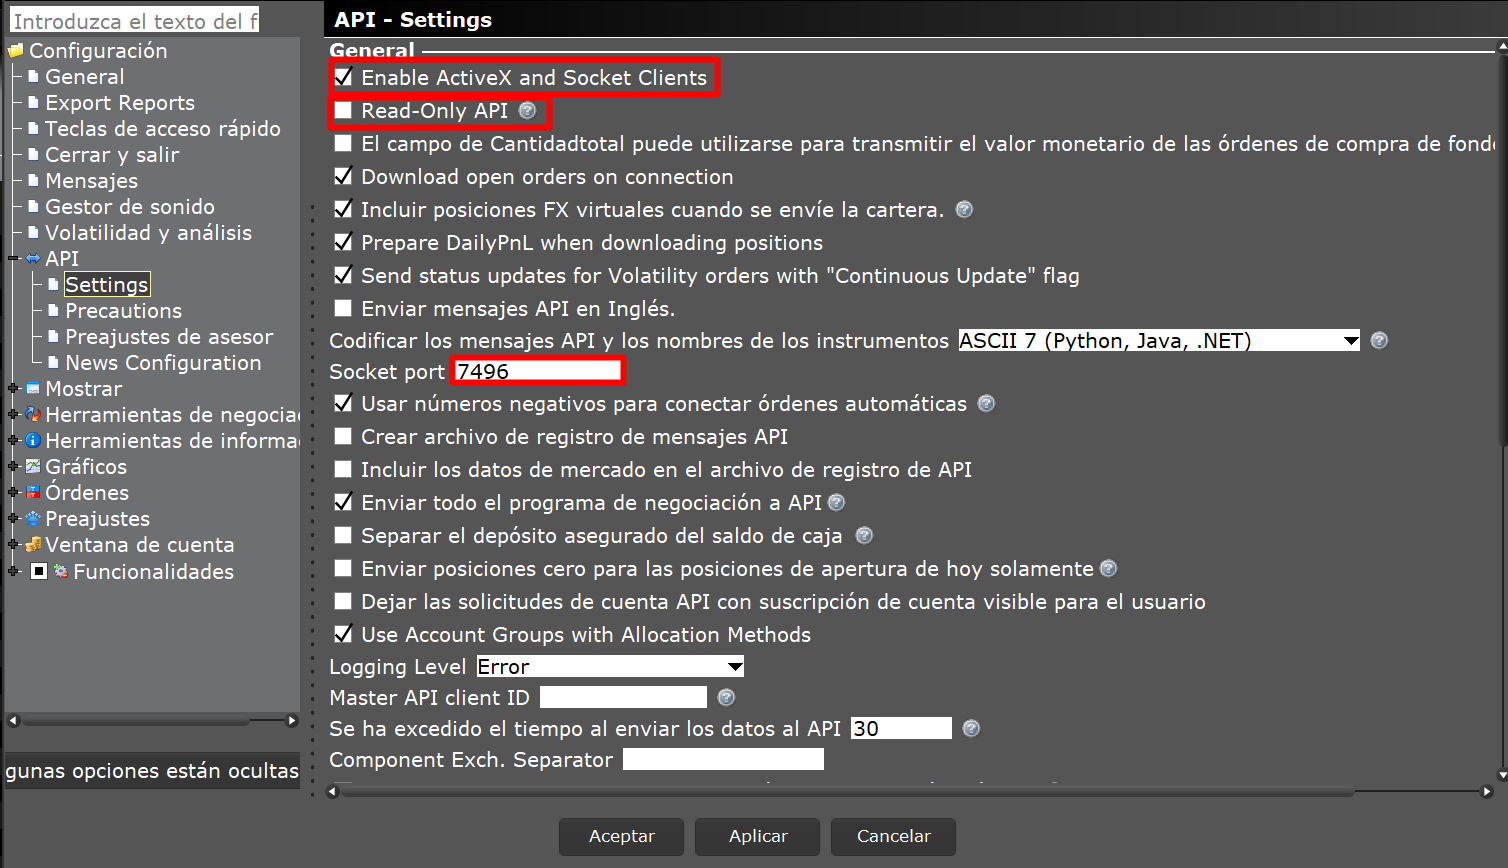

## 1.3. Parámetros clave (host, port, clientId)

**host:** normalmente 127.0.0.1 (misma máquina).

**port:** el puerto configurado en la sección API de TWS (paper con frecuencia 7497).

**clientId:** identificador entero de la sesión API. Debe ser único si existen conexiones concurrentes; reutilizarlo puede provocar desconexiones o rechazo de la conexión.


## 1.4. Fallos típicos y su interpretación

**Connection refused:** el puerto no está escuchando (TWS cerrado, puerto erróneo, API deshabilitada).

**Timeout:** bloqueo por firewall/antivirus o configuración restrictiva de IPs.

**Desconexión inmediata:** conflicto de clientId o restricciones internas de la API.

In [ ]:
from ib_insync import IB, util

# Necesario en notebooks (evita el "event loop is already running")
util.startLoop()

HOST = "127.0.0.1"
PORT = 7497          # Paper por defecto (ajústelo si en TWS ha cambiado el puerto)
CLIENT_ID = 28       # Debe ser único por conexión

ib = IB()

# Si por cualquier motivo ya hubiera una conexión previa en este kernel:
if ib.isConnected():
    ib.disconnect()

ib.connect(HOST, PORT, clientId=CLIENT_ID, timeout=10, readonly=False)

print("Conectado:", ib.isConnected())
print("Server version:", ib.client.serverVersion())
print("Managed accounts:", ib.managedAccounts())
ib.disconnect()


# 2.	Definir contratos de opciones sobre SPY y obtener una cadena de opciones (option chain).

##2.0 Conceptos previos mínimos
###2.0.1 ¿Qué es SPY?
SPY (SPDR S&P 500 ETF Trust) es un ETF que replica el comportamiento del índice S&P 500. Las opciones sobre SPY son, por tanto, opciones sobre un ETF (no sobre un índice). Esta diferencia importa porque, si una opción se ejerce o asigna, la liquidación suele implicar la entrega/recepción de participaciones del ETF (no un pago en efectivo como ocurre típicamente en opciones sobre índices).
###2.0.2  ¿Por qué no SPX?
El SPY suele ser la opción preferida para programar ejemplos prácticos porque:

**1. Disponibilidad de Datos (El factor decisivo)**

**2. Precio y Escala**

**3. Dividendos ($q$)**

¿Y por qué teóricamente el SPX es mejor?

**1. Estilo de Ejercicio (Americano vs Europeo)**

**2. Liquidación**


##2.1 Qué significa “definir un contrato de opción” (en una API)

En una API de mercado (por ejemplo, IBKR TWS API), **definir un contrato significa especificar de forma inequívoca qué instrumento financiero se quiere consultar/negociar.**

Para una opción sobre SPY, los campos esenciales suelen ser:

1. **Subyacente**: SPY

2. **Tipo de instrumento**: opción (en IBKR, secType = "OPT")

3. **Vencimiento**: fecha de expiración (formato típico YYYYMMDD)

4. **Strike**: precio de ejercicio

5. **Derecho**: Call o Put (C o P)

6. **Multiplicador**: normalmente 100 para equity/ETF options

7. **Centro de negociación / ruta**: exchange (por ejemplo SMART en IBKR, que enruta de forma inteligente).

En el caso de IBKR, la documentación del objeto contrato aclara el formato del vencimiento (YYYYMMDD), y recoge explícitamente campos como Strike, Right, Multiplier y Exchange.

Además, IBKR recomienda, cuando sea posible, identificar instrumentos mediante ConId (identificador interno) y exchange, porque reduce ambigüedades.

Hay títulos que cotizan en varias camaras y no necesariamente con el mismo valor, así como opciones que vencen el mismo día a diferentes horas.


##2.2 Qué es una “option chain” (cadena de opciones)

La option chain de un subyacente (SPY) es el catálogo de opciones listadas disponibles para ese subyacente, organizado por:

1. **Vencimientos (expirations)**

2. **Strikes (precios de ejercicio)**

3. **Tipo (calls / puts)**

Es habitual que existan múltiples “cadenas” para el mismo subyacente (por ejemplo, por exchange o por trading class, que puede separar series mensuales y semanales).


Importante: una option chain no siempre incluye precios en tiempo real; a menudo primero se obtiene el universo (strikes/vencimientos) y después, si se desea, se solicita market data (bid/ask, IV, griegas, etc.) para los contratos concretos.


**Procedimiento para obtener la cadena de opciones**
1) **Definir el subyacente (SPY) y obtener su ConId**:
Primero identifico el subyacente; después pido la cadena de opciones de ese subyacente. Para ello se define SPY como instrumento tipo acción/ETF y se solicita al bróker que devuelva sus identificadores internos (incluido ConId).  

2) **Solicitar los parámetros de la cadena con reqSecDefOptParams**:  Obtener cadenas de opciones (listas de expiries y strikes)

3) **Elegir la cadena relevante (exchange / tradingClass)**: Como puede haber varias cadenas, se filtra por el exchange (p. ej. SMART) y, si aplica, por tradingClass.



In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 17 19:57:50 2025

@author: jrg
"""

# -*- coding: utf-8 -*-
"""
@author: jrg
"""
import nest_asyncio  #
nest_asyncio.apply() #

from ib_insync import IB, Stock, Option
import pandas as pd

ib = IB()
# Asegúrate de que el puerto coincida con TWS (7497 es Paper, 7496 es Live)
ib.connect("127.0.0.1", 7497, clientId=4)

# 1) Subyacente SPY (cualificar para obtener conId)
spy = Stock("SPY", "SMART", "USD")
ib.qualifyContracts(spy)

# 2) Pedir parámetros de option chain
chains = ib.reqSecDefOptParams(
    underlyingSymbol="SPY",
    futFopExchange="",
    underlyingSecType="STK",
    underlyingConId=spy.conId
)

# ---- Mostrar resumen de las cadenas disponibles ----
df_chains = pd.DataFrame([{
    "exchange": c.exchange,
    "tradingClass": c.tradingClass,
    "multiplier": c.multiplier,
    "numExpirations": len(c.expirations),
    "numStrikes": len(c.strikes),
} for c in chains]).sort_values(["exchange", "tradingClass"])

print("Resumen de cadenas disponibles:")
print(df_chains.to_string(index=False))

# Elegir cadena (prioriza SMART si existe)
chain = next((c for c in chains if c.exchange == "SMART"), chains[0])

# ---- Mostrar expirations y strikes de la cadena seleccionada ----
expirations = sorted(chain.expirations)
strikes = sorted(chain.strikes)

print("\nCadena seleccionada:")
print(f"  exchange      : {chain.exchange}")
print(f"  tradingClass  : {chain.tradingClass}")
print(f"  multiplier    : {chain.multiplier}")
print(f"  expirations   : {len(expirations)} (muestra: {expirations[:10]})")
print(f"  strikes       : {len(strikes)} (muestra: {strikes[:20]})")

# ---- Mostrar la chain como tabla para un vencimiento concreto ----
expiry = expirations[0]
MAX_STRIKES = 40

df_chain_view = pd.DataFrame({
    "expiry": [expiry] * min(MAX_STRIKES, len(strikes)),
    "strike": strikes[:MAX_STRIKES],
    "call_contract": [f"SPY {expiry} C {k}" for k in strikes[:MAX_STRIKES]],
    "put_contract":  [f"SPY {expiry} P {k}" for k in strikes[:MAX_STRIKES]],
})

print(f"\nVista de option chain (expiry={expiry}, primeras {len(df_chain_view)} filas):")
print(df_chain_view.to_string(index=False))

# (Opcional) Definir contratos reales para un subconjunto
sample_strikes = strikes[:5]
opts = []
for k in sample_strikes:
    opts.append(Option("SPY", expiry, k, "C", chain.exchange, multiplier=str(chain.multiplier)))
    opts.append(Option("SPY", expiry, k, "P", chain.exchange, multiplier=str(chain.multiplier)))

ib.qualifyContracts(*opts)
print("\nEjemplo de contratos cualificados (conId/localSymbol ya resueltos):")
for o in opts:
    print(f"  {o.localSymbol:>18} | conId={o.conId}")

ib.disconnect()

**¿Por qué aparece tradingClass = 2SPY? Opciones estándar vs. FLEX **

En una cadena de opciones, tradingClass es un identificador que utiliza el bróker (IBKR) para distinguir entre “familias” de derivados similares cuando existe más de una serie posible para el mismo subyacente (por ejemplo, mensuales vs. semanales, o series especiales).

En el caso de SPY, tradingClass = SPY suele corresponder a las opciones estándar listadas, con vencimientos y strikes “normales” y una cadena amplia. En cambio, tradingClass = 2SPY apunta a una familia FLEX (Flexible Exchange Options).

Las opciones FLEX son opciones listadas que permiten personalizar términos como el precio de ejercicio, el estilo de ejercicio y/o la fecha de vencimiento, entre otros, y por ello pueden aparecer separadas de la cadena estándar.

En la simbología de FLEX options (opciones flexibles), un número precede al símbolo del subyacente y ese número codifica estilo de ejercicio y tipo de liquidación/entrega. Para equity/ETF:

1 = PM, American, Physical

2 = PM, European, Physical

3 = PM, American, Cash

4 = PM, European, Cash

Por tanto, 2SPY identifica una familia de FLEX equity/ETF options sobre SPY con estilo de ejercicio europeo (solo se ejercen en vencimiento), entrega física (physical delivery), y codificación FLEX (número + subyacente).

Nos quedaremos de momento con las habituales, y obviaremos las 2SPY

In [ ]:
from datetime import datetime
import pandas as pd
from ib_insync import IB, Stock, Contract, util

# ---------------------------------------------------------------------
# 0) FIX para Spyder/Jupyter: evita "This event loop is already running"
# ---------------------------------------------------------------------
def ensure_ipython_loop():
    try:
        from IPython import get_ipython
        ip = get_ipython()
        # startLoop SOLO si estamos en IPython con kernel (notebook/spyder console)
        if ip is not None and getattr(ip, "kernel", None) is not None:
            util.startLoop()
    except Exception:
        pass

ensure_ipython_loop()

# -----------------------
# 1) Conexión a IBKR/TWS
# -----------------------
ib = IB()
ib.connect("127.0.0.1", 7497, clientId=4)  # ajusta puerto/clientId según tu TWS

# -----------------------------
# 2) Subyacente y opt parameters
# -----------------------------
spy = Stock("SPY", "SMART", "USD")
ib.qualifyContracts(spy)

chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)

# Elegimos la cadena estándar (no FLEX): SMART + tradingClass=SPY
chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

expirations = sorted(chain.expirations)
today = datetime.now().strftime("%Y%m%d")

# Para evitar problemas con 0DTE, escogemos el primer expiry estrictamente > hoy
expiry = next((e for e in expirations if e > today), expirations[-1])

print(f"Cadena elegida: exchange={chain.exchange}, tradingClass={chain.tradingClass}, multiplier={chain.multiplier}")
print(f"Expiry seleccionado: {expiry}")

# --------------------------------------------------------------------
# 3) CADENA REAL por vencimiento: reqContractDetails (contratos existentes)
# --------------------------------------------------------------------
# IBKR: con un contrato de opción incompleto (strike no especificado) se obtiene la chain.
# Ojo: es más pesado y puede estar sujeto a pacing (throttling). :contentReference[oaicite:2]{index=2}
tmpl = Contract(
    secType="OPT",
    symbol="SPY",
    currency="USD",
    exchange="SMART",
    lastTradeDateOrContractMonth=expiry,
    multiplier=str(chain.multiplier),
    tradingClass=chain.tradingClass,
    # NOTA: NO ponemos strike y right a propósito para que devuelva todas
)

details = ib.reqContractDetails(tmpl)

if not details:
    raise RuntimeError(
        "reqContractDetails devolvió 0 contratos. "
        "Prueba con otro expiry o revisa permisos/mercado/conexión."
    )

# Construimos un DataFrame con los contratos reales devueltos
rows = []
for d in details:
    c = d.contract
    # Filtramos por seguridad, por si devolviera algo fuera del tradingClass esperado
    if c.symbol != "SPY" or c.secType != "OPT":
        continue
    rows.append({
        "expiry": c.lastTradeDateOrContractMonth,
        "right": c.right,               # 'C' o 'P'
        "strike": c.strike,
        "conId": c.conId,
        "localSymbol": c.localSymbol,
        "exchange": c.exchange,
        "tradingClass": getattr(c, "tradingClass", None),
    })

df = pd.DataFrame(rows)

# Normalizamos/limpiamos
df = df[df["expiry"] == expiry]
df = df[df["right"].isin(["C", "P"])]
df = df.dropna(subset=["strike", "conId"])
df["strike"] = df["strike"].astype(float)

print(f"\nContratos reales recibidos para expiry={expiry}: {len(df)}")
print(df.head(10).to_string(index=False))

# -----------------------------------------
# 4) Presentación tipo "Option Chain" (tabla)
# -----------------------------------------
df_calls = (
    df[df["right"] == "C"][["strike", "localSymbol", "conId"]]
    .rename(columns={"localSymbol": "call_localSymbol", "conId": "call_conId"})
)
df_puts = (
    df[df["right"] == "P"][["strike", "localSymbol", "conId"]]
    .rename(columns={"localSymbol": "put_localSymbol", "conId": "put_conId"})
)

df_chain = (
    df_calls.merge(df_puts, on="strike", how="outer")
    .sort_values("strike")
    .reset_index(drop=True)
)

print(f"\nOption chain REAL (expiry={expiry}) - primeras 30 filas:")
print(df_chain.head(30).to_string(index=False))

# (Opcional) guardar a CSV para entregar / anexar
# df_chain.to_csv(f"SPY_option_chain_{expiry}.csv", index=False)

ib.disconnect()


La cadena de opciones de SPY incluye simultáneamente vencimientos mensuales y vencimientos de corto plazo. Los vencimientos mensuales suelen corresponder al tercer viernes del mes, mientras que el resto de fechas (incluyendo lunes, miércoles y, en SPY, también martes y jueves según el programa aprobado) se clasifican como expiraciones de corto plazo (‘weeklys’).

En SPX, el tercer viernes puede coexistir una serie mensual A.M.-settled (SPX) y una serie semanal P.M.-settled (SPXW). Comparten fecha de calendario, pero no el mismo ‘momento de vencimiento’: la mensual deja de negociarse el día anterior y se liquida por la mañana; la semanal negocia hasta el propio día y se liquida por la tarde.

# 3.	Estimación de la volatilidad implícita a partir de precios de mercado.

Recordemos de la teoria:

  1. Los términos $d_1$ y $d_2$:$$d_1 = \frac{\ln(S/K) + (r - q + \sigma^2/2)T}{\sigma\sqrt{T}}$$$$d_2 = d_1 - \sigma\sqrt{T}$$

  2. La densidad de probabilidad ($N'$):Es la parte de la fórmula que representa la curva de la campana de Gauss:$$N'(d_1) = \frac{1}{\sqrt{2\pi}} e^{-\frac{d_1^2}{2}}$$

  3. Nota sobre la distribución acumulada ($N$): $N(x)$ es la distribución normal estándar acumulada. $N(-x)$ es simplemente $1 - N(x)$.

Método Numérico: Newton-Raphson (El estándar)

Este método usa una volatilidad inicial y la va corrigiendo repetidamente hasta que el precio teórico iguala al precio de mercado.

La fórmula de iteraciónEsta es la fórmula que usarías dentro de un bucle en Python.Fragmento de código$$ \sigma_{n+1} = \sigma_n - \frac{C_{BS}(\sigma_n) - C_{mercado}}{\mathcal{V}(\sigma_n)} $$

Donde:

$\sigma_{n}$: Es tu estimación actual de volatilidad.
$C_{BS}$: Es el precio calculado con la fórmula de Black-Scholes usando $\sigma_n$.$C_{mercado}$: Es el precio real de la opción.
$\mathcal{V}$ (Vega): Es la derivada del precio de la opción respecto a la volatilidad (la sensibilidad). La fórmula de Vega ($\mathcal{V}$) es:

$$ \mathcal{V} = S e^{-qT} \sqrt{T} \frac{1}{\sqrt{2\pi}} e^{-\frac{d_1^2}{2}} $$
(Nota: $\frac{1}{\sqrt{2\pi}} e^{-d_1^2/2}$ es la función de densidad de probabilidad normal standard, a veces denotada como $N'(d_1)$).


Tambien podemos calcular la $ \sigma_n  $ por métodos numéricos, como el **Método de Bisección para Volatilidad Implícita**:

El objetivo es encontrar la raíz $\sigma^*$ tal que:

$$ f(\sigma) = C_{BS}(S, K, T, r, q, \sigma) - C_{mercado} = 0 $$

El algoritmo procede iterativamente reduciendo el intervalo $[\sigma_{low}, \sigma_{high}]$:

1. Calculamos el punto medio:
$$ \sigma_{mid} = \frac{\sigma_{low} + \sigma_{high}}{2} $$

2. Evaluamos la función diferencia:
$$ \Delta = C_{BS}(\sigma_{mid}) - C_{mercado} $$

3. Actualizamos los límites del intervalo basándonos en el signo del error (dado que Vega siempre es positiva):
$$
\begin{cases}
\sigma_{high} = \sigma_{mid} & \text{si } \Delta > 0 \text{ (precio modelo > precio mercado)} \\
\sigma_{low} = \sigma_{mid} & \text{si } \Delta < 0 \text{ (precio modelo < precio mercado)}
\end{cases}
$$

4. Repetimos hasta que $|\Delta| < \epsilon$ (tolerancia).

In [ ]:
# -*- coding: utf-8 -*-
"""

@author: jrg
"""

# ============================================================
# Ejercicio 3: Estimación de volatilidad implícita (IV) ATM
# Subyacente: SPY
# Bróker/API: IBKR TWS + ib_insync
# Método: Black–Scholes (europeo) + bisección para IV
# ============================================================

import math
from datetime import datetime, timedelta
from ib_insync import IB, Stock, Option, util


# ------------------------------------------------------------
# 0) Fix para Spyder/Jupyter: evita "This event loop is already running"
# ------------------------------------------------------------
def ensure_ipython_loop():
    try:
        from IPython import get_ipython
        ip = get_ipython()
        if ip is not None and getattr(ip, "kernel", None) is not None:
            util.startLoop()
    except Exception:
        pass


# ------------------------------------------------------------
# 1) Black–Scholes + implied vol
# ------------------------------------------------------------
def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))


def bs_price(S: float, K: float, T: float, r: float, q: float, sigma: float, right: str) -> float:
    """
    Precio Black–Scholes para opción europea con dividend yield q.
    right: 'C' o 'P'
    """
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0:
        return float("nan")

    d1 = (math.log(S / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    df_r = math.exp(-r * T)
    df_q = math.exp(-q * T)

    if right.upper() == "C":
        return df_q * S * norm_cdf(d1) - df_r * K * norm_cdf(d2)
    else:
        return df_r * K * norm_cdf(-d2) - df_q * S * norm_cdf(-d1)


def implied_vol_bisect(price_mkt: float, S: float, K: float, T: float, r: float, q: float, right: str,
                       lo: float = 1e-6, hi: float = 5.0, iters: int = 100) -> float:
    """
    IV por bisección: encuentra sigma tal que BS_price(sigma) = price_mkt
    Devuelve NaN si no puede asegurar una raíz en [lo, hi]
    """
    if not (math.isfinite(price_mkt) and price_mkt > 0):
        return float("nan")

    f_lo = bs_price(S, K, T, r, q, lo, right) - price_mkt
    f_hi = bs_price(S, K, T, r, q, hi, right) - price_mkt

    if not (math.isfinite(f_lo) and math.isfinite(f_hi)):
        return float("nan")

    # Si no hay cambio de signo, no garantizamos solución en el intervalo
    if f_lo * f_hi > 0:
        return float("nan")

    for _ in range(iters):
        mid = 0.5 * (lo + hi)
        f_mid = bs_price(S, K, T, r, q, mid, right) - price_mkt

        if not math.isfinite(f_mid):
            return float("nan")

        if abs(f_mid) < 1e-8:
            return mid

        if f_lo * f_mid <= 0:
            hi = mid
            f_hi = f_mid
        else:
            lo = mid
            f_lo = f_mid

    return 0.5 * (lo + hi)


# ------------------------------------------------------------
# 2) Helpers: obtener precio y mid
# ------------------------------------------------------------
def wait_for_price(ib: IB, ticker, timeout_s: float = 10.0) -> float:
    """
    Espera a que ticker.marketPrice() sea válido. Devuelve NaN si no llega.
    """
    steps = int(timeout_s / 0.25)
    px = float("nan")
    for _ in range(max(1, steps)):
        ib.sleep(0.25)
        px = ticker.marketPrice()
        if px is not None and math.isfinite(px) and px > 0:
            return float(px)

    # fallback: last
    if ticker.last is not None and math.isfinite(ticker.last) and ticker.last > 0:
        return float(ticker.last)

    return float("nan")


def mid_price(ticker) -> float:
    """
    Mid = (bid+ask)/2 si existe; si no, last como fallback.
    """
    if ticker.bid is not None and ticker.ask is not None:
        if math.isfinite(ticker.bid) and math.isfinite(ticker.ask) and ticker.bid > 0 and ticker.ask > 0:
            return 0.5 * (ticker.bid + ticker.ask)

    if ticker.last is not None and math.isfinite(ticker.last) and ticker.last > 0:
        return float(ticker.last)

    return float("nan")


def yearfrac_from_yyyymmdd(expiry: str) -> float:
    """
    T aproximado en años: días/365 (suficiente para ejercicio).
    """
    exp_dt = datetime.strptime(expiry, "%Y%m%d")
    days = (exp_dt - datetime.now()).days
    return max(days, 1) / 365.0


# ------------------------------------------------------------
# 3) Elegir expiry (~30 días) y strike ATM válido para ese expiry
# ------------------------------------------------------------
def pick_expiry_target(expirations, target_days: int = 30) -> str:
    """
    Elige el expiry más cercano a hoy + target_days (siempre futuro).
    """
    now = datetime.now()
    exp_dt = [(e, datetime.strptime(e, "%Y%m%d")) for e in expirations]
    exp_dt = [(e, d) for e, d in exp_dt if d.date() > now.date()]
    if not exp_dt:
        return sorted(expirations)[-1]
    target = now + timedelta(days=target_days)
    return min(exp_dt, key=lambda x: abs((x[1] - target).days))[0]


def find_valid_atm_strike_for_expiry(
    ib: IB,
    S: float,
    expiry: str,
    strikes,
    multiplier: str,
    trading_class: str,
    exchange: str = "SMART",
    symbol: str = "SPY",
    currency: str = "USD",
    tries: int = 20
) -> tuple[float, Option, Option]:
    """
    Prueba los 'tries' strikes más cercanos al spot y devuelve el primero
    para el que IBKR puede cualificar Call y Put (conId != 0).
    """
    sorted_strikes = sorted(strikes, key=lambda k: abs(float(k) - S))[:tries]

    for K in sorted_strikes:
        K = float(K)
        c = Option(symbol, expiry, K, "C", exchange, currency=currency,
                   multiplier=multiplier, tradingClass=trading_class)
        p = Option(symbol, expiry, K, "P", exchange, currency=currency,
                   multiplier=multiplier, tradingClass=trading_class)

        ib.qualifyContracts(c, p)

        if getattr(c, "conId", 0) not in (0, None) and getattr(p, "conId", 0) not in (0, None):
            return K, c, p

    raise RuntimeError(
        f"No se encontró un strike ATM válido para expiry={expiry} probando {tries} strikes cercanos al spot."
    )


# ------------------------------------------------------------
# MAIN
# ------------------------------------------------------------
if __name__ == "__main__":
    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497           # 7497 paper, 7496 live (ajusta según tu TWS)
    CLIENT_ID = 4

    # Supuestos del ejercicio (ajústalos si tu enunciado lo pide)
    r = 0.04   # tipo libre de riesgo anual (ejemplo)
    q = 0.00   # dividend yield (simplificación)

    ib = IB()
    ib.connect(HOST, PORT, clientId=CLIENT_ID)

    # 1) Forzar datos delayed para minimizar error 10089 si no hay suscripción real-time
    #    1=Live, 2=Frozen, 3=Delayed, 4=Delayed-Frozen
    ib.reqMarketDataType(3)

    # 2) Subyacente SPY
    spy = Stock("SPY", "SMART", "USD")
    ib.qualifyContracts(spy)

    # 3) Spot
    t_spy = ib.reqMktData(spy, "", False, False)
    S = wait_for_price(ib, t_spy, timeout_s=10.0)

    if not (math.isfinite(S) and S > 0):
        ib.disconnect()
        raise RuntimeError(
            "No se pudo obtener el precio de SPY. "
            "Probable causa: falta de permisos/suscripción de market data (también para delayed), "
            "o TWS sin acceso a datos. Revise el error 10089 y su configuración."
        )

    print(f"SPY spot (S): {S:.4f}")

    # 4) Option params (cadena estándar)
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")
    print(f"Cadena: exchange={chain.exchange}, tradingClass={chain.tradingClass}, multiplier={chain.multiplier}")

    # 5) Encontrar strike ATM válido para ese expiry (evita Unknown contract)
    K, optC, optP = find_valid_atm_strike_for_expiry(
        ib=ib,
        S=S,
        expiry=expiry,
        strikes=strikes,
        multiplier=str(chain.multiplier),
        trading_class=chain.tradingClass,
        exchange="SMART",
        tries=25
    )

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call localSymbol={optC.localSymbol} conId={optC.conId}")
    print(f"Put  localSymbol={optP.localSymbol} conId={optP.conId}")

    # 6) Precios de opciones (mid)
    tC = ib.reqMktData(optC, "", False, False)
    tP = ib.reqMktData(optP, "", False, False)

    # Esperar a que lleguen bid/ask o last
    ib.sleep(1.0)

    priceC = mid_price(tC)
    priceP = mid_price(tP)

    print(f"Call price (mid/last): {priceC}")
    print(f"Put  price (mid/last): {priceP}")

    if not (math.isfinite(priceC) and priceC > 0) or not (math.isfinite(priceP) and priceP > 0):
        ib.disconnect()
        raise RuntimeError(
            "No se pudo obtener precio de opciones (Call/Put). "
            "Probable causa: falta de permisos/suscripción de market data de OPTIONS para API."
        )

    # 7) IV (bisección)
    ivC = implied_vol_bisect(priceC, S, K, T, r, q, "C")
    ivP = implied_vol_bisect(priceP, S, K, T, r, q, "P")

    print("\n--- Resultados IV (Black–Scholes + bisección) ---")
    print(f"Supuestos: r={r:.4%}, q={q:.4%}, T={T:.6f} años")
    print(f"IV Call ATM: {ivC:.4%}" if math.isfinite(ivC) else "IV Call ATM: NaN")
    print(f"IV Put  ATM: {ivP:.4%}" if math.isfinite(ivP) else "IV Put  ATM: NaN")

    # (Opcional) comparar con la IV que devuelve IB (si modelGreeks está disponible)
    if getattr(tC, "modelGreeks", None):
        print(f"IB model IV Call: {tC.modelGreeks.impliedVol:.4%}")
    if getattr(tP, "modelGreeks", None):
        print(f"IB model IV Put : {tP.modelGreeks.impliedVol:.4%}")

    ib.disconnect()


Dos notas importantes al respecto:

**Datos de mercado**: IBKR requiere suscripción de pago para datos en tiempo real. Al usar reqMarketDataType(3), aceptamos datos retrasados (15-20 min), lo cual implica que el Spot actual y el precio de la opción podrían tener un desfase temporal ("nonsynchronous data"), lo que ensucia un poco el cálculo de la IV.

**Dividendos ($q$) y tipos ($r$)**:  Las variables $r$ (tasa libre de riesgo) y $q$ (tasa de dividendos) son valores fijos (hardcoded) definidos manualmente. Al poner q=0 en SPY, la IV de la Put sale artificialmente alta y la de la Call baja (debido a la paridad Put-Call).

Para solucionar estos problemas, podemos tomar $r$ de datos de mercado y ajustar $q$ haciendo que sea igual para la call y la put. Además, podemos usar librerias como QuantLib que nos permiten usar modelos mas sofisticados, suavizar curvas etc.

Este método asegura que la curva de volatilidad esté "centrada". Si usamos una $q$ incorrecta, la IV de la Call y la Put ATM serán diferentes (arbitraje teórico).



In [ ]:
# -*- coding: utf-8 -*-
"""
@author: jrg
"""

# -*- coding: utf-8 -*-
"""
Created on Tue Dec 16 19:43:13 2025
Ejercicio Máster: Cálculo IV (Black-Scholes vs QuantLib vs IBKR Model)
"""

import math
import time
from datetime import datetime, timedelta
from ib_insync import IB, Stock, Option, util

# --- Importaciones condicionales ---
try:
    import QuantLib as ql
    HAS_QL = True
except ImportError:
    HAS_QL = False

try:
    import yfinance as yf
    HAS_YF = True
except ImportError:
    HAS_YF = False

# ------------------------------------------------------------
# 0) Fix para Spyder/Jupyter
# ------------------------------------------------------------
def ensure_ipython_loop():
    try:
        from IPython import get_ipython
        ip = get_ipython()
        if ip is not None and getattr(ip, "kernel", None) is not None:
            util.startLoop()
    except Exception:
        pass

# ------------------------------------------------------------
# 1) Funciones Financieras (BS, IV, Calibración)
# ------------------------------------------------------------
def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def get_risk_free_rate_yahoo(default: float = 0.045) -> float:
    """Obtiene la tasa libre de riesgo actual (T-Bill 13 sem) de Yahoo."""
    if not HAS_YF: return default
    try:
        ticker = yf.Ticker("^IRX")
        hist = ticker.history(period="5d")
        if not hist.empty:
            return float(hist["Close"].iloc[-1] / 100.0)
    except Exception:
        pass
    return default

def calculate_implied_q(S: float, K: float, T: float, r: float, priceC: float, priceP: float) -> float:
    """Calcula Dividend Yield (q) implícito por Paridad Put-Call."""
    if S <= 0 or T <= 0: return 0.0
    rhs = priceC - priceP + K * math.exp(-r * T)
    if rhs <= 0: return 0.0
    return -(1.0 / T) * math.log(rhs / S)

def iv_quantlib_american(price_mkt, S, K, expiry_yyyymmdd, r, q, right):
    """Cálculo IV Americana usando QuantLib."""
    if not HAS_QL or not (math.isfinite(price_mkt) and price_mkt > 0):
        return float("nan"), "QL N/A"

    try:
        today = ql.Date.todaysDate()
        ql.Settings.instance().evaluationDate = today
        exp = ql.DateParser.parseFormatted(expiry_yyyymmdd, "%Y%m%d")
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

        opt_type = ql.Option.Call if right.upper() == "C" else ql.Option.Put
        payoff = ql.PlainVanillaPayoff(opt_type, K)
        exercise = ql.AmericanExercise(today, exp)
        option = ql.VanillaOption(payoff, exercise)

        spot_h = ql.QuoteHandle(ql.SimpleQuote(S))
        r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
        q_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, q, day_count))
        vol0 = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, 0.20, day_count))
        process = ql.BlackScholesMertonProcess(spot_h, q_ts, r_ts, vol0)

        if hasattr(ql, "BaroneAdesiWhaleyApproximationEngine"):
            option.setPricingEngine(ql.BaroneAdesiWhaleyApproximationEngine(process))
            eng = "QL BAW"
        else:
            option.setPricingEngine(ql.BinomialVanillaEngine(process, "crr", 100))
            eng = "QL Binomial"

        iv = option.impliedVolatility(price_mkt, process, 1e-4, 100, 1e-4, 4.0)
        return float(iv), eng
    except Exception:
        return float("nan"), "QL Err"

def bs_price(S, K, T, r, q, sigma, right):
    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0: return float("nan")
    d1 = (math.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if right.upper() == "C":
        return math.exp(-q*T)*S*norm_cdf(d1) - math.exp(-r*T)*K*norm_cdf(d2)
    else:
        return math.exp(-r*T)*K*norm_cdf(-d2) - math.exp(-q*T)*S*norm_cdf(-d1)

def implied_vol_bisect(price_mkt, S, K, T, r, q, right, lo=1e-4, hi=4.0):
    if not (math.isfinite(price_mkt) and price_mkt > 0): return float("nan")
    # Filtro básico de arbitraje
    intrinsic = max(0, S*math.exp(-q*T) - K*math.exp(-r*T)) if right == "C" else max(0, K*math.exp(-r*T) - S*math.exp(-q*T))
    if price_mkt < intrinsic: return float("nan")

    f_lo = bs_price(S, K, T, r, q, lo, right) - price_mkt
    f_hi = bs_price(S, K, T, r, q, hi, right) - price_mkt
    if (f_lo * f_hi > 0) or not (math.isfinite(f_lo) and math.isfinite(f_hi)): return float("nan")

    for _ in range(100):
        mid = 0.5 * (lo + hi)
        f_mid = bs_price(S, K, T, r, q, mid, right) - price_mkt
        if abs(f_mid) < 1e-6: return mid
        if f_lo * f_mid <= 0: hi = mid; f_hi = f_mid
        else: lo = mid; f_lo = f_mid
    return 0.5 * (lo + hi)

# ------------------------------------------------------------
# 2) Helpers IBKR
# ------------------------------------------------------------
def wait_for_full_data(ib, ticker, timeout_s=8.0):
    """Espera precio Y greeks (si están disponibles)."""
    end_time = datetime.now() + timedelta(seconds=timeout_s)
    has_price = False
    has_greeks = False

    while datetime.now() < end_time:
        ib.sleep(0.2)
        # Check Precio
        if ticker.marketPrice() > 0 or (ticker.last and ticker.last > 0):
            has_price = True

        # Check Greeks (IV)
        if ticker.modelGreeks and ticker.modelGreeks.impliedVol is not None:
            has_greeks = True

        if has_price and has_greeks:
            break

    # Retornamos el mejor precio que tengamos
    if ticker.marketPrice() > 0: return ticker.marketPrice()
    if ticker.last and ticker.last > 0: return ticker.last
    if ticker.bid > 0 and ticker.ask > 0: return (ticker.bid + ticker.ask)/2
    return float("nan")

def get_ib_model_iv(ticker):
    """Extrae la IV calculada por IB si existe."""
    if ticker.modelGreeks and ticker.modelGreeks.impliedVol:
        return ticker.modelGreeks.impliedVol
    return float("nan")

def pick_expiry_target(expirations, target_days=30):
    now = datetime.now()
    valid = [e for e in expirations if datetime.strptime(e, "%Y%m%d").date() > now.date()]
    if not valid: return sorted(expirations)[-1]
    target = now + timedelta(days=target_days)
    return min(valid, key=lambda x: abs((datetime.strptime(x, "%Y%m%d") - target).days))

def find_valid_atm_strike(ib, S, expiry, strikes, multiplier, trading_class, exchange="SMART"):
    sorted_strikes = sorted(strikes, key=lambda k: abs(float(k) - S))[:10]
    for K in sorted_strikes:
        c = Option("SPY", expiry, float(K), "C", exchange, multiplier=multiplier, tradingClass=trading_class)
        p = Option("SPY", expiry, float(K), "P", exchange, multiplier=multiplier, tradingClass=trading_class)
        ib.qualifyContracts(c, p)
        if c.conId > 0 and p.conId > 0: return float(K), c, p
    raise RuntimeError("No se encontró strike válido")

# ------------------------------------------------------------
# MAIN
# ------------------------------------------------------------
if __name__ == "__main__":
    ensure_ipython_loop()
    HOST = "127.0.0.1"; PORT = 7497; CLIENT_ID = 6 # ID cambiado

    ib = IB()
    try:
        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)

        # 1. SPY Spot
        spy = Stock("SPY", "SMART", "USD")
        ib.qualifyContracts(spy)
        t_spy = ib.reqMktData(spy, "", False, False)
        # Espera simple para spot
        ib.sleep(2)
        S = t_spy.marketPrice() if t_spy.marketPrice() > 0 else (t_spy.last if t_spy.last else float("nan"))

        if math.isnan(S): raise RuntimeError("No hay precio SPY")
        print(f"SPY Spot: {S:.2f}")

        # 2. Cadena
        chains = ib.reqSecDefOptParams(spy.symbol, "", spy.secType, spy.conId)
        chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")
        expiry = pick_expiry_target(chain.expirations, 30)
        exp_date = datetime.strptime(expiry, "%Y%m%d")
        T = max((exp_date - datetime.now()).days, 1) / 365.0
        K, optC, optP = find_valid_atm_strike(ib, S, expiry, chain.strikes, chain.multiplier, chain.tradingClass)

        print(f"Expiry: {expiry} (T={T:.3f}) | Strike: {K}")

        # 3. Precios Opciones + IV IBKR
        # SOLICITAMOS '106' (IV) en genericTickList
        tC = ib.reqMktData(optC, "106", False, False)
        tP = ib.reqMktData(optP, "106", False, False)

        # Esperamos a que lleguen datos (Precio y Greeks)
        pC = wait_for_full_data(ib, tC, 8.0)
        pP = wait_for_full_data(ib, tP, 8.0)

        print(f"Precios: Call={pC:.2f} | Put={pP:.2f}")

        if math.isnan(pC) or math.isnan(pP):
            print("ERROR: Faltan precios de opciones.")
        else:
            # 4. Calibración
            r_calib = get_risk_free_rate_yahoo(default=0.045)
            q_calib = calculate_implied_q(S, K, T, r_calib, pC, pP)

            print(f"\n--- Calibración ---")
            print(f"r (Libre Riesgo): {r_calib:.2%}")
            print(f"q (Implied Yield): {q_calib:.2%}")

            # 5. Cálculos IV
            # Nuestro cálculo (Black-Scholes Europeo)
            ivC_bs = implied_vol_bisect(pC, S, K, T, r_calib, q_calib, "C")
            ivP_bs = implied_vol_bisect(pP, S, K, T, r_calib, q_calib, "P")

            # Cálculo QuantLib (Americano)
            ivC_ql, engC = iv_quantlib_american(pC, S, K, expiry, r_calib, q_calib, "C")
            ivP_ql, engP = iv_quantlib_american(pP, S, K, expiry, r_calib, q_calib, "P")

            # Dato de IB (Modelo del Bróker)
            ivC_ib = get_ib_model_iv(tC)
            ivP_ib = get_ib_model_iv(tP)

            # 6. Tabla Comparativa Final
            print("\n" + "="*60)
            print(f"{'MÉTODO':<20} | {'IV CALL':<12} | {'IV PUT':<12} | {'NOTAS':<10}")
            print("-" * 60)

            # BS
            note_bs = "Europea"
            print(f"{'Black-Scholes':<20} | {ivC_bs:<12.2%} | {ivP_bs:<12.2%} | {note_bs}")

            # QuantLib
            note_ql = "Amer/BAW"
            if HAS_QL:
                print(f"{'QuantLib (Amer)':<20} | {ivC_ql:<12.2%} | {ivP_ql:<12.2%} | {note_ql}")
            else:
                print(f"{'QuantLib (Amer)':<20} | {'N/A':<12} | {'N/A':<12} | No Install")

            # IBKR
            # Nota: IB usa tasas y dividendos propios, no necesariamente los nuestros
            val_ib_c = f"{ivC_ib:.2%}" if math.isfinite(ivC_ib) else "N/A*"
            val_ib_p = f"{ivP_ib:.2%}" if math.isfinite(ivP_ib) else "N/A*"
            print(f"{'Interactive Brokers':<20} | {val_ib_c:<12} | {val_ib_p:<12} | {'Model Tick'}")
            print("="*60)

            if not math.isfinite(ivC_ib):
                print("* Nota: Si IB IV es N/A, verifique permisos de 'Option Greeks' o espere más tiempo.")

    except Exception as e:
        print(f"Error: {e}")
    finally:
        ib.disconnect()

## Análisis del codigo

Esta implementación estima la **Volatilidad Implícita (IV)** mediante una calibración dinámica con datos de mercado en tiempo real.

### 1. Consistencia Interna: Calibración Dinámica
A diferencia de los enfoques anterior que utilizan valores fijos, este script calibra las variables exógenas para minimizar el error del modelo y garantizar la consistencia de precios:

* **Tasa Libre de Riesgo ($r$):** Se extrae dinámicamente de la curva de T-Bills a 13 semanas (`^IRX`) vía Yahoo Finance, reflejando el coste de oportunidad real del mercado. Quedaria aun por mejorar la interpolación de tipos a cada plazo.

* **Dividendo Implícito ($q$):** Se deduce $q$ mediante la **Paridad Put-Call**. Esto fuerza la ausencia de arbitraje estático en el momento de la ejecución, asegurando que la volatilidad implicita (IV) de Calls y Puts converja:

$$q_{IV} = - \frac{1}{T} \ln \left( \frac{C_{mkt} - P_{mkt} + K e^{-rT}}{S} \right)$$

### 2. Benchmarking de Modelos: Europeo vs. Americano
El script implementa un enfoque comparativo para cuantificar el impacto de la prima de ejercicio anticipado:

* **Solver Propio (Black-Scholes):** Utiliza un método numérico de **Bisección** sobre el modelo Merton (Europeo). Es computacionalmente eficiente y robusto, sirviendo como línea base (*baseline*).
* **QuantLib (Barone-Adesi-Whaley):** Se utiliza para valorar la opción considerando su naturaleza **Americana** (típica en ETFs como SPY).
    * *Nota:* Para opciones *At-The-Money* (ATM) y vencimientos cortos, la divergencia entre ambos modelos suele ser despreciable, lo que valida la precisión del solver numérico propio.

### 3. Ingeniería de Datos (IBKR)
Dada la naturaleza asíncrona de la API de Interactive Brokers, se implementó la función `wait_for_full_data`. Esto mitiga el riesgo de cálculos erróneos por latencia de red, asegurando que tanto el precio (`marketPrice`) como las griegas del bróker (`modelGreeks`) estén sincronizados antes del cálculo.

### 4. Hipótesis de Modelado
Se asume un **rendimiento por dividendo continuo** ($q$) para el periodo de vida de la opción. Aunque el SPY distribuye dividendos discretos, la aproximación continua derivada de la paridad Put-Call es suficiente para "suavizar" el efecto de los flujos de caja y permite una comparación directa de volatilidades en vencimientos menores a un año.



# **4.	Calcular precio teórico y griegas (Δ, Γ, Θ, Vega, Rho) con vuestro propio código (p.ej. Black–Scholes) y comparación con los del Broker.**


Para añadir el cálculo del resto de griegas (Delta, Gamma, Vega, Theta, Rho), debemos expandir tanto la parte de cálculo manual (usando las fórmulas analíticas de Black-Scholes) como la parte de recuperación de datos de Interactive Brokers.

**Fórmulas de las Griegas (Black-Scholes Europeo)**

Para una opción con precio del subyacente $S$, strike $K$, tiempo $T$, tasa $r$, dividendo $q$ y volatilidad $\sigma$:

Recordamos:
$$d_1 = \frac{\ln(S/K) + (r - q + 0.5\sigma^2)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

$$N'(x) = \frac{1}{\sqrt{2\pi}} e^{-0.5 x^2} \quad (\text{Densidad de probabilidad})$$



<br>
  $$
\begin{array}{|l|l|c|c|}
\hline
\textbf{Griega} & \textbf{Significado} & \textbf{Fórmula Call} & \textbf{Fórmula Put} \\ \hline
\textbf{Delta } (\Delta) & \text{Sensibilidad a } S & e^{-qT} N(d_1) & -e^{-qT} N(-d_1) \\ \hline
\textbf{Gamma } (\Gamma) & \text{Curvatura } (\partial^2 / \partial S^2) & \frac{e^{-qT} N'(d_1)}{S \sigma \sqrt{T}} & \text{Igual a la Call} \\ \hline
\textbf{Vega } (\nu) & \text{Sensibilidad a } \sigma \text{ (1\%)} & \frac{S e^{-qT} N'(d_1) \sqrt{T}}{100} & \text{Igual a la Call} \\ \hline
\textbf{Theta } (\Theta) & \text{Tiempo (1 día)} & \frac{1}{365} \left[ -\frac{S \sigma e^{-qT} N'(d_1)}{2\sqrt{T}} - r K e^{-rT} N(d_2) + q S e^{-qT} N(d_1) \right] & \frac{1}{365} \left[ -\frac{S \sigma e^{-qT} N'(d_1)}{2\sqrt{T}} + r K e^{-rT} N(-d_2) - q S e^{-qT} N(-d_1) \right] \\ \hline
\textbf{Rho } (\rho) & \text{Sensibilidad a } r \text{ (1\%)} & \frac{K T e^{-rT} N(d_2)}{100} & \frac{-K T e^{-rT} N(-d_2)}{100} \\ \hline
\end{array}
$$



## Matriz de Griegas

Esta implementación expande el modelo de valoración para incluir la gestión de riesgos completa mediante el cálculo de las sensibilidades de primer y segundo orden.

### 1. Cobertura Completa de Riesgos ($\Theta$ y $\rho$)
A diferencia de las calculadoras básicas, este script incorpora dos métricas críticas a menudo ignoradas en ejercicios académicos simples:

* **Theta ($\Theta$ - Time Decay):** Se ha normalizado el resultado para representar la pérdida de valor **por día** (dividido por 365), que es el estándar de mercado para los traders, en lugar de la tasa anualizada teórica de las fórmulas de texto.
* **Rho ($\rho$ - Sensibilidad a Tipos):** Se calcula el impacto de un movimiento del **1%** en la tasa libre de riesgo (dividido por 100). Aunque Rho suele ser despreciable en entornos de tipos cero, con tasas actuales (~4.5%), se convierte en un factor relevante para opciones LEAPS (largo plazo).

### 2. Modelado Americano Avanzado (QuantLib)
Para el cálculo con QuantLib, se ha sustituido el motor genérico por `BjerksundStenslandApproximationEngine`.
* **Justificación:** El SPY es una opción de estilo **Americano**. El modelo de Bjerksund-Stensland (1993) es superior a Black-Scholes para estimar el valor del ejercicio anticipado, ofreciendo Griegas más precisas, especialmente para Puts muy  *In-The-Money* (ITM) o Calls ante dividendos altos.


### 3. Gestión de Limitaciones del Bróker (IBKR)

Se ha implementado una lógica defensiva para la lectura de datos de Interactive Brokers:
* **Ausencia de Rho:** La API de IBKR frecuentemente omite el valor de Rho en su objeto `modelGreeks` estándar. El script detecta esta ausencia y reporta "N/A" limpiamente en lugar de fallar, manteniendo la integridad de la ejecución para el resto de las métricas.
* **Consistencia de Unidades:** Se valida que las Griegas de IBKR (que suelen venir normalizadas) sean comparables en escala con nuestros cálculos manuales (ej. Vega como cambio por punto porcentual de volatilidad).

### 4. Calibración Dinámica (Reiteración)
Se mantiene la metodología de consistencia interna:
$$r_{mkt} \leftarrow \text{Yahoo Finance (^IRX)}$$
$$q_{implied} \leftarrow \text{Paridad Put-Call}$$
Esto asegura que las Griegas calculadas manualmente reflejen las condiciones reales de liquidez del mercado y no supuestos teóricos arbitrarios.


Nota: es ncesario tener instalado pandas y plotly, ya que importa las librerías necesarias para manejar los datos en tablas y generar gráficos interactivos.



In [ ]:
# -*- coding: utf-8 -*-
"""
Ejercicio Máster: Griegas Completas (SOLUCIÓN DEFINITIVA QUANTLIB + THETA/RHO)
Cambios:
1. Cálculo de Rho añadido a BS Manual y QuantLib.
2. Inclusión de Theta y Rho en el reporte final.
3. Manejo de Rho inexistente en IBKR.
"""

import math
from ib_insync import IB, Stock, Option, util

# --- Importaciones condicionales ---
try:
    import QuantLib as ql
    HAS_QL = True
except ImportError:
    HAS_QL = False

try:
    import yfinance as yf
    HAS_YF = True
except ImportError:
    HAS_YF = False

# ------------------------------------------------------------
# 1) Matemáticas Financieras (BS Manual + Rho)
# ------------------------------------------------------------
def ensure_ipython_loop():
    try:
        from IPython import get_ipython
        if get_ipython() and getattr(get_ipython(), "kernel", None):
            util.startLoop()
    except: pass

def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_pdf(x):
    return (1.0 / math.sqrt(2.0 * math.pi)) * math.exp(-0.5 * x * x)

def bs_greeks_manual(S, K, T, r, q, sigma, right):
    """
    Calcula Griegas europeas manualmente.
    Theta: Time decay por día (dividido por 365).
    Rho: Sensibilidad a tipos de interés (por 1% de cambio).
    """
    res = {"iv": sigma, "delta": float("nan"), "gamma": float("nan"),
           "vega": float("nan"), "theta": float("nan"), "rho": float("nan")}

    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0: return res

    d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    nd1 = norm_cdf(d1); n_d1 = norm_pdf(d1)
    eqT = math.exp(-q * T); erT = math.exp(-r * T); sqrtT = math.sqrt(T)

    res["gamma"] = (eqT * n_d1) / (S * sigma * sqrtT)
    res["vega"]  = (S * eqT * n_d1 * sqrtT) / 100.0

    if right == "C":
        nd2 = norm_cdf(d2)
        res["delta"] = eqT * nd1
        # Theta Call
        res["theta"] = (-(S * eqT * n_d1 * sigma) / (2 * sqrtT)
                        - r * K * erT * nd2
                        + q * S * eqT * nd1) / 365.0
        # Rho Call (Dividido entre 100 para sens. por 1%)
        res["rho"]   = (K * T * erT * nd2) / 100.0
    else:
        n_md2 = norm_cdf(-d2)
        nd1_neg = norm_cdf(-d1)
        res["delta"] = eqT * (nd1 - 1.0)
        # Theta Put
        res["theta"] = (-(S * eqT * n_d1 * sigma) / (2 * sqrtT)
                        + r * K * erT * n_md2
                        - q * S * eqT * nd1_neg) / 365.0
        # Rho Put (Dividido entre 100 para sens. por 1%)
        res["rho"]   = (-K * T * erT * n_md2) / 100.0

    return res

def implied_vol_bisect(price, S, K, T, r, q, right):
    def price_bs(s):
        d1 = (math.log(S/K) + (r - q + 0.5*s**2)*T) / (s*math.sqrt(T))
        d2 = d1 - s*math.sqrt(T)
        if right == "C": return math.exp(-q*T)*S*norm_cdf(d1) - math.exp(-r*T)*K*norm_cdf(d2)
        return math.exp(-r*T)*K*norm_cdf(-d2) - math.exp(-q*T)*S*norm_cdf(-d1)

    if price <= 0: return float("nan")
    lo, hi = 1e-4, 4.0
    for _ in range(50):
        mid = (lo+hi)/2
        p = price_bs(mid)
        if abs(p - price) < 1e-4: return mid
        if p > price: hi = mid
        else: lo = mid
    return (lo+hi)/2

# ------------------------------------------------------------
# 2) QuantLib Griegas (Con Rho y Theta)
# ------------------------------------------------------------
def ql_greeks_american(price, S, K, expiry_str, r, q, right):
    res = {"iv": float("nan"), "delta": float("nan"), "gamma": float("nan"),
           "vega": float("nan"), "theta": float("nan"), "rho": float("nan")}

    if not HAS_QL or price <= 0: return res

    try:
        today = ql.Date.todaysDate()
        ql.Settings.instance().evaluationDate = today
        exp_date = ql.DateParser.parseFormatted(expiry_str, "%Y%m%d")

        opt_type = ql.Option.Call if right == "C" else ql.Option.Put
        payoff = ql.PlainVanillaPayoff(opt_type, K)
        exercise = ql.AmericanExercise(today, exp_date)

        spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
        day_count = ql.Actual365Fixed()
        r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
        q_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, q, day_count))

        # --- FASE 1: IV con Barone-Adesi ---
        option_calc = ql.VanillaOption(payoff, exercise)
        vol_dummy = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.UnitedStates(ql.UnitedStates.NYSE), 0.20, day_count))
        process_calc = ql.BlackScholesMertonProcess(spot_handle, q_ts, r_ts, vol_dummy)
        option_calc.setPricingEngine(ql.BaroneAdesiWhaleyApproximationEngine(process_calc))

        try:
            iv = option_calc.impliedVolatility(price, process_calc, 1e-4, 100, 1e-4, 4.0)
        except RuntimeError:
            return res

        res["iv"] = iv

        # --- FASE 2: Griegas con Bjerksund-Stensland ---
        option_greeks = ql.VanillaOption(payoff, exercise)
        vol_final = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.UnitedStates(ql.UnitedStates.NYSE), iv, day_count))
        process_final = ql.BlackScholesMertonProcess(spot_handle, q_ts, r_ts, vol_final)

        option_greeks.setPricingEngine(ql.BjerksundStenslandApproximationEngine(process_final))

        res["delta"] = option_greeks.delta()
        res["gamma"] = option_greeks.gamma()
        res["vega"]  = option_greeks.vega() / 100.0
        res["theta"] = option_greeks.theta() / 365.0
        res["rho"]   = option_greeks.rho() / 100.0  # Rho por 1% cambio

    except Exception as e:
        print(f"Error interno QuantLib: {e}")
        pass

    return res

# ------------------------------------------------------------
# 3) PRECIO ROBUSTO & MAIN
# ------------------------------------------------------------
def on_ticker_update(ticker):
    pass

def get_smart_price(ticker):
    if ticker.last and math.isfinite(ticker.last) and ticker.last > 0: return ticker.last
    if ticker.close and math.isfinite(ticker.close) and ticker.close > 0: return ticker.close
    if ticker.modelGreeks and ticker.modelGreeks.optPrice:
        mp = ticker.modelGreeks.optPrice
        if math.isfinite(mp) and mp > 0: return mp
    if (ticker.bid and ticker.ask and ticker.bid > 0 and ticker.ask > 0):
        return (ticker.bid + ticker.ask) / 2.0
    return 0.0

if __name__ == "__main__":
    import datetime as dt
    ensure_ipython_loop()
    HOST = "127.0.0.1"; PORT = 7497; CLIENT_ID = 15

    ib = IB()
    try:
        print("Conectando...")
        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)

        # 1. SPY Spot
        spy = Stock("SPY", "SMART", "USD")
        ib.qualifyContracts(spy)
        t_spy = ib.reqMktData(spy, "", False, False)
        ib.sleep(1)
        S = get_smart_price(t_spy)
        print(f"SPY Spot (Smart): {S:.2f}")

        if S <= 0: raise RuntimeError("No se pudo obtener precio del SPY.")

        # 2. Cadena y Contrato
        chains = ib.reqSecDefOptParams(spy.symbol, "", spy.secType, spy.conId)
        chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

        now = dt.datetime.now()
        target = now + dt.timedelta(days=30)
        exps = [e for e in chain.expirations if dt.datetime.strptime(e, "%Y%m%d").date() > now.date()]
        expiry = min(exps, key=lambda x: abs((dt.datetime.strptime(x, "%Y%m%d") - target).days))
        T = max((dt.datetime.strptime(expiry, "%Y%m%d") - now).days, 1) / 365.0

        strikes = [k for k in chain.strikes if k % 1 == 0]
        K = sorted(strikes, key=lambda k: abs(k - S))[0]

        optC = Option("SPY", expiry, K, "C", "SMART", tradingClass="SPY", multiplier="100")
        optP = Option("SPY", expiry, K, "P", "SMART", tradingClass="SPY", multiplier="100")
        ib.qualifyContracts(optC, optP)

        print(f"Monitorizando: {expiry} Strike {K}...")

        # 3. SUSCRIPCIÓN
        tC = ib.reqMktData(optC, "100,101,104,106", False, False)
        tP = ib.reqMktData(optP, "100,101,104,106", False, False)
        tC.updateEvent += on_ticker_update
        tP.updateEvent += on_ticker_update

        print("\n--- ESPERANDO DATOS (hasta 10 seg) ---")
        pC, pP = 0.0, 0.0

        for i in range(40):
            ib.sleep(0.25)
            pC = get_smart_price(tC)
            pP = get_smart_price(tP)

            has_ib_greeks = (tC.modelGreeks and tC.modelGreeks.impliedVol is not None)

            if pC > 0 and pP > 0 and has_ib_greeks:
                print(">>> Datos completos (Precios + Griegas IB) recibidos.")
                break

        print("--- FIN ESPERA ---")
        print(f"\nPrecios Finales Utilizados:")
        print(f"Call: {pC:.2f}")
        print(f"Put : {pP:.2f}")

        if pC > 0 and pP > 0:
            # Calibrar r y q
            r = 0.045
            if HAS_YF:
                try: r = float(yf.Ticker("^IRX").history(period="5d")["Close"].iloc[-1])/100.0
                except: pass

            rhs = pC - pP + K * math.exp(-r * T)
            q = -(1.0/T)*math.log(rhs/S) if rhs > 0 else 0.0

            print(f"Params Calibrados: r={r:.2%} q={q:.2%}")

            # Griegas Manuales
            ivC_man = implied_vol_bisect(pC, S, K, T, r, q, "C")
            gx_man = bs_greeks_manual(S, K, T, r, q, ivC_man, "C")

            # Griegas QL
            gx_ql = ql_greeks_american(pC, S, K, expiry, r, q, "C")

            # Griegas IB
            gx_ib = tC.modelGreeks

            print(f"\nRESUMEN FINAL CALL (Strike {K}):")
            # Cabecera ampliada para Theta y Rho
            header = f"{'Modelo':<10} | {'IV':<7} | {'Delta':<6} | {'Gamma':<6} | {'Vega':<6} | {'Theta':<7} | {'Rho':<6}"
            print(header)
            print("-" * len(header))

            # 1. Manual BS
            print(f"{'B-S':<10} | {gx_man['iv']:.2%} | {gx_man['delta']:.3f}  | {gx_man['gamma']:.3f}  | {gx_man['vega']:.3f}  | {gx_man['theta']:.3f}   | {gx_man['rho']:.3f}")

            # 2. QuantLib
            if HAS_QL:
                print(f"{'QuantLib':<10} | {gx_ql['iv']:.2%} | {gx_ql['delta']:.3f}  | {gx_ql['gamma']:.3f}  | {gx_ql['vega']:.3f}  | {gx_ql['theta']:.3f}   | {gx_ql['rho']:.3f}")
            else:
                print(f"{'QuantLib':<10} | No instalado")

            # 3. IBKR (Manejo de Rho inexistente)
            if gx_ib and gx_ib.impliedVol:
                # IB devuelve Theta diario, pero NO Rho
                theta_str = f"{gx_ib.theta:.3f}" if gx_ib.theta is not None else "N/A"
                rho_str   = "N/A" # IB no provee Rho en modelGreeks estándar

                print(f"{'IBKR':<10} | {gx_ib.impliedVol:.2%} | {gx_ib.delta:.3f}  | {gx_ib.gamma:.3f}  | {gx_ib.vega:.3f}  | {theta_str:<7} | {rho_str:<6}")

                if gx_ib.optPrice:
                    print(f"\nNota: IB usó precio modelo interno: {gx_ib.optPrice:.2f}")
            else:
                print(f"{'IBKR':<10} | (Sin datos)")

        else:
            print(f"FALLO: No se encontraron precios válidos (pC={pC}, pP={pP}).")

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        ib.disconnect()

Ahora repetimos para los strikes proximos y obtenemos la curva de volatilidad y la representacion de las griegas para un vencimiento.

## Superficie de Volatilidad y Robustez de API

La siguiente implementación escala el modelo de valoración individual a un análisis de **estructura de mercado**, procesando múltiples strikes simultáneamente para visualizar el comportamiento del activo subyacente.

### 1. Manejo Defensivo de la API
Una limitación documentada de la API de IBKR es la inconsistencia en el envío de griegas de segundo orden o menor impacto, específicamente **Rho** ($\rho$).
* **El Problema:** Intentar acceder a `ticker.modelGreeks.rho` lanza un `AttributeError` porque el campo a menudo no existe en la respuesta del servidor.
* **La Solución:** El código implementa una asignación explícita de `NaN` para Rho en la sección de IBKR, delegando el cálculo de esta sensibilidad exclusivamente a los motores internos (**Manual B-S** y **QuantLib**). Esto convierte a nuestro código en la *única fuente* de información sobre el riesgo de tipos de interés, ya que el bróker no lo provee por defecto.

### 2. Volatility Smile
El script genera un gráfico de dispersión (`Scatter Plot`) comparando la Volatilidad Implícita (IV) de tres fuentes.

* **Utilidad:** Permite detectar visualmente el **Skew** (sesgo) del mercado. En índices como el SPY, es normal observar una pendiente negativa (los Puts OTM tienen mayor IV que los Calls OTM) debido a la demanda de protección contra caídas (*crash protection*).
* **Validación:** Si las curvas "Manual" y "QuantLib" se superponen casi perfectamente a la curva "IBKR", se confirma que nuestra calibración de $r$ y $q$ es correcta para todo el rango de precios.

### 3. Matriz de Griegas (Plotly Subplots)
Se generan 5 paneles verticales para analizar la sensibilidad en función del Strike ($K$):
* **Delta ($\Delta$):** Muestra la probabilidad aproximada de que la opción termine *In-The-Money*.
* **Gamma ($\Gamma$):** Muestra la convexidad. Se espera un pico máximo alrededor del precio Spot ($S$).
* **Theta ($\Theta$):** Visualiza la erosión temporal. Es fundamental validar que sea negativa para opciones compradas (Long).
* **Rho ($\rho$):** Al graficar solo los datos Manuales y de QuantLib (ya que IBKR no los tiene), este panel revela la exposición oculta a los tipos de interés, crítica en el entorno macroeconómico actual.

### 4. Calibración Global de Dividendos
A diferencia del ejercicio anterior (calculadora simple), aquí se utiliza un algoritmo de búsqueda para encontrar el par Call/Put más cercano al dinero (ATM) de toda la cadena descargada.
$$q_{calib} \leftarrow \text{Paridad Put-Call en el Strike ATM}$$
Este valor único de $q$ se aplica luego a toda la curva, lo cual es una práctica estándar para mantener la consistencia monótona de la superficie de volatilidad.

In [ ]:
# -*- coding: utf-8 -*-
"""
Ejercicio Máster V12: Superficie de Volatilidad (FIX RHO IBKR)
- CORRECCIÓN CRÍTICA: La API de IBKR no envía Rho en 'OptionComputation'.
  Se ha eliminado la lectura de 'mg.rho' para evitar el AttributeError.
- Se mantiene el cálculo de Rho Manual y QuantLib.
"""

import math
import datetime as dt
import time
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ib_insync import IB, Stock, Option, util

# --- Importaciones condicionales ---
try:
    import QuantLib as ql
    HAS_QL = True
except ImportError:
    HAS_QL = False

try:
    import yfinance as yf
    HAS_YF = True
except ImportError:
    HAS_YF = False

# ------------------------------------------------------------
# 1) Matemáticas Financieras (BS Manual)
# ------------------------------------------------------------
def ensure_ipython_loop():
    try:
        from IPython import get_ipython
        if get_ipython() and getattr(get_ipython(), "kernel", None):
            util.startLoop()
    except: pass

def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_pdf(x):
    return (1.0 / math.sqrt(2.0 * math.pi)) * math.exp(-0.5 * x * x)

def bs_greeks_manual(S, K, T, r, q, sigma, right):
    res = {"delta": float("nan"), "gamma": float("nan"), "vega": float("nan"),
           "theta": float("nan"), "rho": float("nan")}

    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0.001 or math.isnan(sigma): return res

    try:
        d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
        d2 = d1 - sigma * math.sqrt(T)
        nd1 = norm_cdf(d1); n_d1 = norm_pdf(d1)
        eqT = math.exp(-q * T); erT = math.exp(-r * T); sqrtT = math.sqrt(T)

        res["gamma"] = (eqT * n_d1) / (S * sigma * sqrtT)
        res["vega"]  = (S * eqT * n_d1 * sqrtT) / 100.0

        if right == "C":
            nd2 = norm_cdf(d2)
            res["delta"] = eqT * nd1
            res["theta"] = (-(S * eqT * n_d1 * sigma) / (2 * sqrtT) - r * K * erT * nd2 + q * S * eqT * nd1) / 365.0
            # Rho Call: K * T * e^(-rT) * N(d2) / 100
            res["rho"]   = (K * T * erT * nd2) / 100.0
        else:
            n_md2 = norm_cdf(-d2)
            nd1_neg = norm_cdf(-d1)
            res["delta"] = eqT * (nd1 - 1.0)
            res["theta"] = (-(S * eqT * n_d1 * sigma) / (2 * sqrtT) + r * K * erT * n_md2 - q * S * eqT * nd1_neg) / 365.0
            # Rho Put: -K * T * e^(-rT) * N(-d2) / 100
            res["rho"]   = (-K * T * erT * n_md2) / 100.0
    except: pass
    return res

def implied_vol_bisect(price, S, K, T, r, q, right):
    def price_bs(s):
        if s < 1e-5: s = 1e-5
        d1 = (math.log(S/K) + (r - q + 0.5*s**2)*T) / (s*math.sqrt(T))
        d2 = d1 - s*math.sqrt(T)
        if right == "C": return math.exp(-q*T)*S*norm_cdf(d1) - math.exp(-r*T)*K*norm_cdf(d2)
        return math.exp(-r*T)*K*norm_cdf(-d2) - math.exp(-q*T)*S*norm_cdf(-d1)

    if price <= 0.01: return float("nan")
    lo, hi = 1e-4, 5.0
    for _ in range(100):
        mid = (lo+hi)/2
        try:
            p = price_bs(mid)
            if abs(p - price) < 1e-4: return mid
            if p > price: hi = mid
            else: lo = mid
        except: return float("nan")

    res = (lo+hi)/2
    if res > 4.9 or res < 0.001: return float("nan")
    return res

# ------------------------------------------------------------
# 2) QuantLib Griegas
# ------------------------------------------------------------
def ql_greeks_american_robust(price, S, K, expiry_str, r, q, right):
    res = {"iv": float("nan"), "delta": float("nan"), "gamma": float("nan"),
           "vega": float("nan"), "theta": float("nan"), "rho": float("nan")}
    if not HAS_QL or price <= 0.01: return res

    try:
        today = ql.Date.todaysDate()
        ql.Settings.instance().evaluationDate = today
        exp_date = ql.DateParser.parseFormatted(expiry_str, "%Y%m%d")

        opt_type = ql.Option.Call if right == "C" else ql.Option.Put
        payoff = ql.PlainVanillaPayoff(opt_type, K)
        exercise = ql.AmericanExercise(today, exp_date)

        spot_handle = ql.QuoteHandle(ql.SimpleQuote(S))
        day_count = ql.Actual365Fixed()
        r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
        q_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, q, day_count))

        # FASE 1: IV
        option_calc = ql.VanillaOption(payoff, exercise)
        vol_dummy = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.UnitedStates(ql.UnitedStates.NYSE), 0.20, day_count))
        process_calc = ql.BlackScholesMertonProcess(spot_handle, q_ts, r_ts, vol_dummy)
        option_calc.setPricingEngine(ql.BaroneAdesiWhaleyApproximationEngine(process_calc))

        try:
            iv = option_calc.impliedVolatility(price, process_calc, 1e-4, 200, 1e-5, 4.0)
        except: return res
        res["iv"] = iv

        # FASE 2: Griegas
        option_greeks = ql.VanillaOption(payoff, exercise)
        vol_final = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.UnitedStates(ql.UnitedStates.NYSE), iv, day_count))
        process_final = ql.BlackScholesMertonProcess(spot_handle, q_ts, r_ts, vol_final)
        option_greeks.setPricingEngine(ql.BjerksundStenslandApproximationEngine(process_final))

        res["delta"] = option_greeks.delta()
        res["gamma"] = option_greeks.gamma()
        res["vega"]  = option_greeks.vega() / 100.0
        res["theta"] = option_greeks.theta() / 365.0
        res["rho"]   = option_greeks.rho() / 100.0
    except: pass
    return res

# ------------------------------------------------------------
# 3) VISUALIZACIÓN
# ------------------------------------------------------------
def plot_results(df, ticker_name, expiry_str):
    if df.empty:
        print("No hay datos válidos para graficar.")
        return

    df_c = df[df['Type'] == 'C'].sort_values(by='Strike')
    df_p = df[df['Type'] == 'P'].sort_values(by='Strike')

    spot_line = dict(color="gray", dash="dash", width=1)
    current_spot = df['Spot'].iloc[0]

    # --- GRÁFICO 1: Smile IV ---
    fig_iv = go.Figure()

    # IBKR
    fig_iv.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['IV_IB'], mode='lines+markers', name='IV IBKR (Call)', line=dict(color='blue')))
    fig_iv.add_trace(go.Scatter(x=df_p['Strike'], y=df_p['IV_IB'], mode='lines+markers', name='IV IBKR (Put)', line=dict(color='red')))
    # MANUAL
    fig_iv.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['IV_Man'], mode='lines', name='IV Manual (Call)', line=dict(color='orange', dash='dot')))
    fig_iv.add_trace(go.Scatter(x=df_p['Strike'], y=df_p['IV_Man'], mode='lines', name='IV Manual (Put)', line=dict(color='darkorange', dash='dot')))
    # QL
    if HAS_QL:
        fig_iv.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['IV_QL'], mode='lines', name='IV QL (Call)', line=dict(color='cyan', width=1, dash='dot')))
        fig_iv.add_trace(go.Scatter(x=df_p['Strike'], y=df_p['IV_QL'], mode='lines', name='IV QL (Put)', line=dict(color='magenta', width=1, dash='dot')))

    fig_iv.add_vline(x=current_spot, line=spot_line, annotation_text="Spot")
    fig_iv.update_layout(title=f"Smile Volatilidad: {ticker_name} ({expiry_str})", xaxis_title="Strike", yaxis_title="IV %", hovermode="x unified")

    # --- GRÁFICO 2: Griegas ---
    fig_greeks = make_subplots(rows=5, cols=1, shared_xaxes=True,
                               subplot_titles=("Delta", "Gamma", "Vega", "Theta", "Rho (Tipos de Interés)"))

    # 1. Delta
    fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Delta_IB'], name='Delta IB (Call)', line=dict(color='blue'), legendgroup='1'), row=1, col=1)
    fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Delta_Man'], name='Delta Man (Call)', line=dict(color='orange', dash='dash'), legendgroup='1'), row=1, col=1)
    if HAS_QL: fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Delta_QL'], name='Delta QL (Call)', line=dict(color='cyan', dash='dot'), legendgroup='1'), row=1, col=1)

    # 2. Gamma
    fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Gamma_IB'], name='Gamma IB', line=dict(color='green'), legendgroup='2'), row=2, col=1)
    fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Gamma_Man'], name='Gamma Man', line=dict(color='orange', dash='dash'), legendgroup='2'), row=2, col=1)
    if HAS_QL: fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Gamma_QL'], name='Gamma QL', line=dict(color='cyan', dash='dot'), legendgroup='2'), row=2, col=1)

    # 3. Vega
    fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Vega_IB'], name='Vega IB', line=dict(color='purple'), legendgroup='3'), row=3, col=1)
    fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Vega_Man'], name='Vega Man', line=dict(color='orange', dash='dash'), legendgroup='3'), row=3, col=1)
    if HAS_QL: fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Vega_QL'], name='Vega QL', line=dict(color='cyan', dash='dot'), legendgroup='3'), row=3, col=1)

    # 4. Theta
    fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Theta_IB'], name='Theta IB (Call)', line=dict(color='brown'), legendgroup='4'), row=4, col=1)
    fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Theta_Man'], name='Theta Man (Call)', line=dict(color='orange', dash='dash'), legendgroup='4'), row=4, col=1)
    if HAS_QL: fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Theta_QL'], name='Theta QL (Call)', line=dict(color='cyan', dash='dot'), legendgroup='4'), row=4, col=1)

    # 5. Rho (IBKR no envía Rho, así que solo graficamos Man y QL)
    fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Rho_Man'], name='Rho Man (Call)', line=dict(color='orange', dash='dash'), legendgroup='5'), row=5, col=1)
    if HAS_QL: fig_greeks.add_trace(go.Scatter(x=df_c['Strike'], y=df_c['Rho_QL'], name='Rho QL (Call)', line=dict(color='cyan', dash='dot'), legendgroup='5'), row=5, col=1)
    # Put Rho
    fig_greeks.add_trace(go.Scatter(x=df_p['Strike'], y=df_p['Rho_Man'], name='Rho Man (Put)', line=dict(color='darkorange', dash='dot'), legendgroup='5'), row=5, col=1)
    if HAS_QL: fig_greeks.add_trace(go.Scatter(x=df_p['Strike'], y=df_p['Rho_QL'], name='Rho QL (Put)', line=dict(color='magenta', dash='dot'), legendgroup='5'), row=5, col=1)


    for i in range(1,6): fig_greeks.add_vline(x=current_spot, line=spot_line, row=i, col=1)

    fig_greeks.update_layout(height=1500, title_text=f"Griegas Completas (+Rho): {ticker_name}", hovermode="x unified")

    try:
        fig_iv.show()
        fig_greeks.show()
    except: pass

    fig_iv.write_html(f"smile_V12_{ticker_name}.html")
    fig_greeks.write_html(f"griegas_V12_{ticker_name}.html")
    print(f"\n[OK] Gráficos guardados: smile_V12_{ticker_name}.html y griegas_V12...")

# ------------------------------------------------------------
# 4) MAIN
# ------------------------------------------------------------
if __name__ == "__main__":
    ensure_ipython_loop()
    HOST = "127.0.0.1"; PORT = 7497; CLIENT_ID = 25
    SYMBOL = "SPY"

    ib = IB()
    try:
        print("--- INICIO DEL ANÁLISIS V12 (FIX RHO) ---")
        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)

        # 1. Spot
        underlying = Stock(SYMBOL, "SMART", "USD")
        ib.qualifyContracts(underlying)
        t_spot = ib.reqMktData(underlying, "", False, False)
        ib.sleep(1.5)
        S_init = t_spot.last if t_spot.last > 0 else (t_spot.close if t_spot.close > 0 else 0)
        if S_init <= 0:
             bars = ib.reqHistoricalData(underlying, endDateTime='', durationStr='1 D', barSizeSetting='1 day', whatToShow='TRADES', useRTH=True)
             if bars: S_init = bars[-1].close
        print(f"Spot Inicial: {S_init:.2f}")

        # 2. Cadena
        chains = ib.reqSecDefOptParams(underlying.symbol, "", underlying.secType, underlying.conId)
        chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == SYMBOL)

        now_date = dt.datetime.now().date()
        target_date = now_date + dt.timedelta(days=30)

        valid_exps = []
        for e_str in chain.expirations:
            ed = dt.datetime.strptime(e_str, "%Y%m%d").date()
            if ed > now_date: valid_exps.append(e_str)

        expiry = min(valid_exps, key=lambda x: abs((dt.datetime.strptime(x, "%Y%m%d").date() - target_date).days))
        days_to_exp = (dt.datetime.strptime(expiry, "%Y%m%d").date() - now_date).days
        T = max(days_to_exp, 1) / 365.0
        print(f"Vencimiento: {expiry} ({days_to_exp} días, T={T:.4f})")

        # 3. Filtrar
        min_k = S_init * 0.85; max_k = S_init * 1.15
        filtered_strikes = sorted([k for k in chain.strikes if min_k <= k <= max_k and k % 1 == 0])

        # 4. Batch Request
        print(f"Solicitando {len(filtered_strikes)} strikes...")
        contracts = []
        for K in filtered_strikes:
            contracts.append(Option(SYMBOL, expiry, K, "C", "SMART", tradingClass=SYMBOL, multiplier="100"))
            contracts.append(Option(SYMBOL, expiry, K, "P", "SMART", tradingClass=SYMBOL, multiplier="100"))

        ib.qualifyContracts(*contracts)
        valid_contracts = [c for c in contracts if c.conId > 0]
        tickers = [ib.reqMktData(c, "100,101,106", False, False) for c in valid_contracts]

        print("Esperando datos (6s)...")
        ib.sleep(6)

        # 5. Sincronizar S
        if t_spot.last > 0: S_final = t_spot.last
        elif t_spot.close > 0: S_final = t_spot.close
        else: S_final = S_init

        # 6. Calibrar r y q
        r = 0.045
        if HAS_YF:
            try:
                h = yf.Ticker("^IRX").history(period="5d")
                if not h.empty: r = float(h["Close"].iloc[-1]) / 100.0
            except: pass

        q = 0.015
        best_diff = 999; pC_atm = 0; pP_atm = 0; k_atm = 0
        for t in tickers:
            if t.contract.right == "C":
                mid_C = (t.bid + t.ask)/2.0 if (t.bid>0) else t.last
                if mid_C > 0 and abs(t.contract.strike - S_final) < best_diff:
                    t_put = next((x for x in tickers if x.contract.strike == t.contract.strike and x.contract.right == "P"), None)
                    if t_put:
                        mid_P = (t_put.bid + t_put.ask)/2.0 if (t_put.bid>0) else t_put.last
                        if mid_P > 0:
                            best_diff = abs(t.contract.strike - S_final)
                            pC_atm = mid_C; pP_atm = mid_P; k_atm = t.contract.strike
        if pC_atm > 0:
            rhs = pC_atm - pP_atm + k_atm * math.exp(-r * T)
            if rhs > 0:
                q_calib = -(1.0/T)*math.log(rhs/S_final)
                if -0.01 < q_calib < 0.10: q = q_calib

        print(f"PARAMETROS: Spot={S_final:.2f}, r={r:.2%}, q={q:.2%}")

        # 7. BUCLE
        data_rows = []
        for t in tickers:
            input_price = t.modelGreeks.optPrice if (t.modelGreeks and t.modelGreeks.optPrice) else ((t.bid + t.ask)/2.0 if t.bid>0 else t.last)
            if input_price < 0.05: continue

            K = t.contract.strike; right = t.contract.right

            iv_man = implied_vol_bisect(input_price, S_final, K, T, r, q, right)
            gx_man = bs_greeks_manual(S_final, K, T, r, q, iv_man, right)
            gx_ql = ql_greeks_american_robust(input_price, S_final, K, expiry, r, q, right)

            mg = t.modelGreeks
            iv_ib = mg.impliedVol if (mg and mg.impliedVol) else float("nan")
            delta_ib = mg.delta if (mg and mg.delta) else float("nan")
            gamma_ib = mg.gamma if (mg and mg.gamma) else float("nan")
            vega_ib = mg.vega if (mg and mg.vega) else float("nan")
            theta_ib = mg.theta if (mg and mg.theta) else float("nan")

            # --- CORRECCIÓN RHO ---
            # Asumimos que IB no manda Rho (evita el crash)
            rho_ib = float("nan")

            data_rows.append({
                "Strike": K, "Type": right, "Spot": S_final, "Price_Used": input_price,
                "IV_Man": iv_man * 100, "IV_QL": gx_ql["iv"] * 100 if not math.isnan(gx_ql["iv"]) else float("nan"), "IV_IB": iv_ib * 100,

                "Delta_Man": gx_man["delta"], "Delta_QL": gx_ql["delta"], "Delta_IB": delta_ib,
                "Gamma_Man": gx_man["gamma"], "Gamma_QL": gx_ql["gamma"], "Gamma_IB": gamma_ib,
                "Vega_Man": gx_man["vega"],   "Vega_QL": gx_ql["vega"],   "Vega_IB": vega_ib,
                "Theta_Man": gx_man["theta"], "Theta_QL": gx_ql["theta"], "Theta_IB": theta_ib,
                "Rho_Man": gx_man["rho"],     "Rho_QL": gx_ql["rho"],     "Rho_IB": rho_ib,
            })

        # 8. Graficar
        df_results = pd.DataFrame(data_rows)
        df_results = df_results.dropna(subset=['IV_IB'])
        print(f"Procesadas {len(df_results)} opciones.")
        plot_results(df_results, SYMBOL, expiry)

    except Exception as e:
        print(f"ERROR: {e}")
        import traceback
        traceback.print_exc()
    finally:
        if ib.isConnected(): ib.disconnect()
        input("\nFin. Presiona ENTER.")

para este vencimiento y estas condiciones de mercado, el "Premium Americano" es casi despreciable, por lo que Black-Scholes (la fórmula sencilla) funciona sorprendentemente bien incluso para opciones americanas como las del SPY.

##5.	Visualización de smiles y una mini-superficie de volatilidad (strike × vencimiento).

La superficie de volatilidad es una representación gráfica tridimensional que muestra cómo la volatilidad implícita de las opciones (el riesgo futuro esperado) varía según dos dimensiones principales: el precio de ejercicio (strike price) y el tiempo hasta el vencimiento (maturity). Es esencial para traders y analistas, ya que revela la "sonrisa" o "sesgo" de volatilidad (volatility skew/smile) y la estructura temporal, ayudando a valorar opciones no cotizadas y entender las expectativas del mercado sobre el movimiento futuro de un activo subyacente.

 **Componentes clave:**
 * Eje X: Precio de ejercicio (Strike Price).
 * Eje Y: Tiempo hasta el vencimiento (Time to Maturity).
 * Eje Z: Volatilidad Implícita (IV), derivada de los precios de mercado de las opciones.

 **¿Por qué es Importante?:**

 * Muestra las Expectativas del Mercado: No toda la volatilidad es igual. La superficie captura cómo el mercado espera que varíe el riesgo para diferentes horizontes temporales y niveles de precio.

 * Revela el "Skew" y "Smile": Si las opciones "in the money" (ITM) y "out of the money" (OTM) tienen volatilidades implícitas diferentes, se forma una curva (sonrisa o sesgo) que indica la percepción del riesgo de cola (eventos extremos).

 * Valoración de Opciones: Permite estimar el precio de opciones que no cotizan directamente en el mercado, interpolando entre los puntos conocidos en la superficie.

 * Análisis de Riesgo: Identifica periodos o niveles de precio donde el activo es percibido como más riesgoso (mayor volatilidad) o más estable (menor volatilidad). En resumen, es una herramienta visual fundamental para entender la dinámica de precios y riesgos en el mercado de derivados, combinando el sesgo (skew) y la estructura temporal de la volatilidad en un solo gráfico.


Finalmente, podemos ver la superficie de volatilidad con diferentes vencimientos.

## Superficie de Volatilidad 3D Híbrida

Esta implementación modela la volatilidad implícita como una función bivariante $\sigma(K, T)$, donde $K$ es el strike y $T$ el tiempo al vencimiento.

### 1. Arquitectura de Datos Híbrida (Tolerancia a Fallos)
Uno de los mayores desafíos en la valoración cuantitativa es la integridad de los datos ("Data Completeness"). Las APIs de mercado a menudo tienen "huecos".
* **Estrategia:** El script implementa un patrón de diseño *try-else-compute*.
    1.  **Intento 1 (IBKR):** Se consulta `ticker.modelGreeks.impliedVol`. Es la fuente preferida porque el bróker ajusta sus modelos por dividendos discretos y curvas de tipos complejas.
    2.  **Fallback (Manual):** Si IBKR devuelve `NaN` o `None`, el sistema no descarta el strike. En su lugar, invoca `implied_vol_fallback`, un solver numérico propio (Bisección sobre Black-Scholes) para rellenar el dato faltante.
    * **Resultado:** Esto maximiza la densidad de la malla 3D, suavizando la visualización final.

### 2. Detección de Liquidez Real (`reqContractDetails`)
En lugar de generar strikes teóricos matemáticamente (que podrían no existir), el script solicita al mercado:
* `ib.reqContractDetails` descarga la definición oficial de los contratos disponibles en la bolsa (SMART).
* Esto evita errores de "Contrato no encontrado" y asegura que solo se procesen strikes que realmente son negociables.
* Se aplica un filtro de rango (`RANGE_PCT = 0.12`) para centrarse en la zona de liquidez relevante ($\pm 12\%$ del Spot), ignorando opciones profundas OTM/ITM que suelen tener *spreads* muy anchos y datos ruidosos.
* Pedir 100+ tickers simultáneos a la API de IB puede causar bloqueos por "Pacing Violation" (exceso de solicitudes por segundo). Se reduce la muestra a la mitad cuando hay muchos strikes, asi se mantie la forma de la curva sin saturar la conexión.

### 3. Visualización 3D (Plotly)
Se utiliza una representación de malla (`Mesh3d`) para renderizar la superficie.

* **Eje X (Strike):** Muestra el "Skew" (sonrisa/mueca de volatilidad).
* **Eje Y (Tiempo):** Muestra la "Estructura Temporal" (Term Structure). En mercados normales, se espera contango (IV sube con el tiempo) o backwardation invertida en crisis.
* **Agrupación:** El código promedia (`groupby`) las volatilidades de Calls y Puts para el mismo strike. Teóricamente deberían ser idénticas (por paridad Put-Call), y promediarlas reduce el ruido de microestructura (bid-ask bounce).

In [ ]:
# -*- coding: utf-8 -*-
"""
Ejercicio Máster V15: Superficie de Volatilidad 3D (Híbrida & Validada)
-----------------------------------------------------------------------
1. Detecta strikes REALES usando 'reqContractDetails'.
2. Prioriza la IV oficial de IBKR (ModelGreeks).
3. Fallback: Calcula IV a mano si IBKR no envía dato.
4. Grafica Superficie 3D interactiva.
"""

import math
import datetime as dt
import pandas as pd
import plotly.graph_objects as go
from ib_insync import IB, Stock, Option, util

# --- 1. MATEMÁTICAS DE APOYO (SOLO PARA FALLBACK) ---
def ensure_ipython_loop():
    try:
        from IPython import get_ipython
        if get_ipython() and getattr(get_ipython(), "kernel", None):
            util.startLoop()
    except: pass

def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def implied_vol_fallback(price, S, K, T, r, q, right):
    """Calcula IV a mano solo si IB no la envía."""
    if price <= 0.05 or T <= 0: return float("nan")

    def price_bs(s):
        if s < 1e-4: s = 1e-4
        d1 = (math.log(S/K) + (r - q + 0.5*s**2)*T) / (s*math.sqrt(T))
        d2 = d1 - s*math.sqrt(T)
        if right == "C":
            return math.exp(-q*T)*S*norm_cdf(d1) - math.exp(-r*T)*K*norm_cdf(d2)
        else:
            return math.exp(-r*T)*K*norm_cdf(-d2) - math.exp(-q*T)*S*norm_cdf(-d1)

    lo, hi = 1e-4, 4.0
    for _ in range(20):
        mid = (lo+hi)/2
        try:
            p = price_bs(mid)
            if abs(p - price) < 1e-3: return mid
            if p > price: hi = mid
            else: lo = mid
        except: return float("nan")
    return (lo+hi)/2

# --- 2. VISUALIZACIÓN ---
def plot_surface_v15(df, ticker):
    if df.empty:
        print("Datos insuficientes para graficar.")
        return

    # Limpieza de valores extremos para que la gráfica no se deforme
    df = df[(df['IV'] > 1) & (df['IV'] < 100)]

    # Agrupar Calls y Puts del mismo strike/vencimiento para suavizar
    df_surf = df.groupby(['Strike', 'T_Years'])[['IV']].mean().reset_index()

    fig = go.Figure()

    # Malla 3D
    fig.add_trace(go.Mesh3d(
        x=df_surf['Strike'],
        y=df_surf['T_Years'],
        z=df_surf['IV'],
        intensity=df_surf['IV'],
        colorscale='Viridis',
        opacity=0.9,
        flatshading=True,
        name='IV Surface'
    ))

    # Puntos reales
    fig.add_trace(go.Scatter3d(
        x=df_surf['Strike'],
        y=df_surf['T_Years'],
        z=df_surf['IV'],
        mode='markers',
        marker=dict(size=2, color='black'),
        name='Datos'
    ))

    fig.update_layout(
        title=f"Superficie de Volatilidad (IBKR Data): {ticker}",
        scene=dict(
            xaxis_title='Strike ($)',
            yaxis_title='Tiempo (Años)',
            zaxis_title='IV (%)',
            camera=dict(eye=dict(x=1.5, y=1.5, z=0.5))
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        height=900
    )

    filename = f"Superficie_V15_{ticker}.html"
    fig.write_html(filename)
    print(f"\n[ÉXITO] Gráfico guardado: {filename}")
    try: fig.show()
    except: pass

# --- 3. CORE LOGIC ---
if __name__ == "__main__":
    ensure_ipython_loop()

    # PARAMETROS
    HOST = "127.0.0.1"; PORT = 7497; CLIENT_ID = 88
    SYMBOL = "SPY"
    R_RATE = 0.045
    DIV_YIELD = 0.015
    RANGE_PCT = 0.12  # Descargar +/- 12% del Spot

    ib = IB()
    try:
        print(f"--- INICIO V15: SUPERFICIE HÍBRIDA ({SYMBOL}) ---")
        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3) # Delayed

        # A) Spot
        underlying = Stock(SYMBOL, "SMART", "USD")
        ib.qualifyContracts(underlying)
        tick = ib.reqMktData(underlying, "", False, False)
        ib.sleep(2)
        S_ref = tick.last if tick.last > 0 else (tick.close if tick.close > 0 else 0)

        # Histórico de seguridad
        if S_ref <= 0:
            print("Spot no disponible en tick, buscando histórico...")
            bars = ib.reqHistoricalData(underlying, '', '1 D', '1 day', 'TRADES', 1, 1, False, [])
            if bars: S_ref = bars[-1].close

        print(f"Precio Spot Referencia: {S_ref:.2f}")
        if S_ref == 0: raise Exception("No hay precio spot.")

        # B) Definición de Cadena
        chains = ib.reqSecDefOptParams(underlying.symbol, "", underlying.secType, underlying.conId)
        chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == SYMBOL)

        # Filtrar fechas (Próximos 5 meses)
        now = dt.datetime.now().date()
        valid_exps = sorted([dt.datetime.strptime(e, "%Y%m%d").date() for e in chain.expirations if dt.datetime.strptime(e, "%Y%m%d").date() > now + dt.timedelta(days=2)])
        target_exps = valid_exps[:5]

        print(f"Vencimientos: {[d.strftime('%Y-%m-%d') for d in target_exps]}")

        all_data = []

        # C) Bucle Principal
        for exp in target_exps:
            exp_str = exp.strftime("%Y%m%d")
            T = (exp - now).days / 365.0
            print(f"\n---> Vencimiento: {exp_str} (T={T:.3f})")

            # 1. Validar Strikes Reales
            print("     Validando contratos existentes...")
            contract_tpl = Option(SYMBOL, exp_str, exchange='SMART')
            cds = ib.reqContractDetails(contract_tpl)

            # Crear conjunto de strikes únicos que existen
            real_strikes = set(cd.contract.strike for cd in cds)

            # Filtrar por rango de precio
            min_k = S_ref * (1 - RANGE_PCT)
            max_k = S_ref * (1 + RANGE_PCT)
            target_strikes = sorted([k for k in real_strikes if min_k <= k <= max_k])

            # Optimización: si hay demasiados, saltar (decimación)
            if len(target_strikes) > 40: target_strikes = target_strikes[::2]

            print(f"     Solicitando datos para {len(target_strikes)} strikes...")

            # 2. Pedir Datos (Griegas incluidas)
            contracts = []
            for K in target_strikes:
                contracts.append(Option(SYMBOL, exp_str, K, "C", "SMART"))
                contracts.append(Option(SYMBOL, exp_str, K, "P", "SMART"))

            ib.qualifyContracts(*contracts)
            # Tick 106 = Option Implied Vol
            tickers = [ib.reqMktData(c, "100,101,106", False, False) for c in contracts]

            ib.sleep(4) # Esperar a que lleguen los ticks

            # 3. Procesar Ticks (Lógica Híbrida)
            valid_count = 0
            for t in tickers:
                mid = (t.bid + t.ask)/2 if (t.bid > 0) else t.last
                if mid < 0.05: continue

                iv_final = float("nan")
                source = ""

                # FUENTE 1: IBKR (Model Greeks)
                if t.modelGreeks and t.modelGreeks.impliedVol:
                    iv_ib = t.modelGreeks.impliedVol
                    # Filtro de cordura (a veces manda infinitos)
                    if 0.01 < iv_ib < 5.0:
                        iv_final = iv_ib * 100
                        source = "IBKR"

                # FUENTE 2: Cálculo Manual (Fallback)
                if math.isnan(iv_final):
                    iv_man = implied_vol_fallback(mid, S_ref, t.contract.strike, T, R_RATE, DIV_YIELD, t.contract.right)
                    if not math.isnan(iv_man):
                        iv_final = iv_man * 100
                        source = "MANUAL"

                if not math.isnan(iv_final):
                    valid_count += 1
                    all_data.append({
                        "Strike": t.contract.strike,
                        "T_Years": T,
                        "Type": t.contract.right,
                        "IV": iv_final,
                        "Source": source
                    })

            # Limpieza
            for t in tickers: ib.cancelMktData(t.contract)
            print(f"     Datos válidos recibidos: {valid_count}")

        # D) Resultado Final
        df = pd.DataFrame(all_data)
        if not df.empty:
            print(f"\nGenerando superficie con {len(df)} puntos...")
            # Mostrar conteo de fuentes
            print(df['Source'].value_counts())
            plot_surface_v15(df, SYMBOL)
        else:
            print("No se encontraron datos.")

    except Exception as e:
        print(f"ERROR: {e}")
        import traceback
        traceback.print_exc()
    finally:
        ib.disconnect()
        print("Desconectado.")

##6.	Representar la Evolución temporal histórica de la opción (griegas y payoff).

## Visualización Histórica

Esta implementación se centra en la **trazabilidad visual** de la evolución de una opción. Al analizar series temporales largas, es crucial correlacionar eventos de precio (Subplot 1) con cambios en el riesgo (Subplots 3 y 4).

### 1. Mejora de Legibilidad (Configuración de Ejes)
En gráficos de múltiples paneles (*subplots*) que comparten el eje X (`shared_xaxes=True`), la configuración por defecto suele ocultar las fechas en los gráficos superiores para ahorrar espacio. Esto se evita.

### 2. Reconstrucción de Datos ("Data Stitching")
La función `get_data_brute_force` aborda una limitación común en contratos de opciones: la falta de historial "Diario" continuo.
* **Lógica de Fallback:**
    1.  Intenta pedir velas de `1 day`.
    2.  Si falla (común en opciones con poco volumen), pide velas de `1 hour` para los últimos meses.
    3.  **Resampling:** Utiliza Pandas (`resample('D').last()`) para sintetizar una vela diaria válida a partir de los cierres horarios. Esto permite reconstruir gráficos de largo plazo incluso con datos fragmentados.

### 3. Dinámica de Griegas Históricas
El gráfico resultante permite observar fenómenos clásicos:
* **Decaimiento de Theta ($\Theta$):** Se observará cómo la curva violeta (Theta) se vuelve más negativa exponencialmente a medida que la fecha se acerca al vencimiento (Eje X avanza).
* **Sensibilidad del Delta ($\Delta$):** Se puede correlacionar visualmente cómo el Delta (azul) reacciona a los movimientos del subyacente (gris punteado), verificando la "Gamma" del contrato.

In [ ]:
# -*- coding: utf-8 -*-
"""
Ejercicio Máster V29: Visualización Densa (Fechas en todos los ejes)
--------------------------------------------------------------------
MEJORAS VISUALES:
1. Fechas repetidas en los 4 subgráficos (showticklabels=True).
2. Mayor densidad de fechas (nticks aumentado).
3. Mantiene la lógica de reconstrucción de datos (V28).
"""

import math
import datetime as dt
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ib_insync import IB, Stock, Option, util

# --- 1. MATEMÁTICAS ---
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_pdf(x):
    return (1.0 / math.sqrt(2.0 * math.pi)) * math.exp(-0.5 * x * x)

def calculate_greeks_manual(S, K, T, r, q, price, right):
    if T <= 0.001 or price <= 0.01: return {}
    def bs_price(vol):
        if vol < 1e-4: vol = 1e-4
        d1 = (math.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*math.sqrt(T))
        d2 = d1 - vol*math.sqrt(T)
        if right == "C": return math.exp(-q*T)*S*norm_cdf(d1) - math.exp(-r*T)*K*norm_cdf(d2)
        else: return math.exp(-r*T)*K*norm_cdf(-d2) - math.exp(-q*T)*S*norm_cdf(-d1)

    lo, hi = 0.001, 5.0
    iv = float("nan")
    for _ in range(20):
        mid = (lo+hi)/2
        p = bs_price(mid)
        if abs(p - price) < 0.01:
            iv = mid; break
        if p > price: hi = mid
        else: lo = mid
    if math.isnan(iv): iv = (lo+hi)/2

    res = {"IV": iv * 100}
    try:
        d1 = (math.log(S/K) + (r - q + 0.5*iv**2)*T) / (iv*math.sqrt(T))
        d2 = d1 - iv*math.sqrt(T)
        n_d1 = norm_pdf(d1); eqT = math.exp(-q*T); erT = math.exp(-r*T)
        res["Gamma"] = (eqT * n_d1) / (S * iv * math.sqrt(T))
        if right == "C":
            res["Delta"] = eqT * norm_cdf(d1)
            res["Theta"] = (-(S * eqT * n_d1 * iv)/(2*math.sqrt(T)) - r*K*erT*norm_cdf(d2) + q*S*eqT*norm_cdf(d1)) / 365.0
        else:
            res["Delta"] = eqT * (norm_cdf(d1) - 1.0)
            res["Theta"] = (-(S * eqT * n_d1 * iv)/(2*math.sqrt(T)) + r*K*erT*norm_cdf(-d2) - q*S*eqT*norm_cdf(-d1)) / 365.0
    except: pass
    return res

# --- 2. GRÁFICO (MODIFICADO V29) ---
def plot_history_v29(df, ticker, title_str):
    if df.empty: return

    days = len(df)

    # Nota: shared_xaxes=True normalmente oculta las etiquetas superiores.
    # Lo mantenemos True para el zoom, pero forzaremos las etiquetas abajo.
    fig = make_subplots(
        rows=4, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.08, # Un poco más de espacio para que quepan las fechas
        subplot_titles=(f"Precio ({days} días)", "IV %", "Delta", "Theta"),
        specs=[[{"secondary_y": True}], [{}], [{}], [{}]]
    )

    # Datos
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Opt_Close'], name='Opción', line=dict(color='#00CC96')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Spot_Close'], name='SPY', line=dict(color='gray', dash='dot')), row=1, col=1, secondary_y=True)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['IV'], name='IV %', line=dict(color='#EF553B')), row=2, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Delta'], name='Delta', line=dict(color='#636EFA')), row=3, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Theta'], name='Theta', line=dict(color='#AB63FA')), row=4, col=1)

    # --- CONFIGURACIÓN EJE X (LA CLAVE) ---
    fig.update_xaxes(
        tickangle=-45,      # Rotación oblicua
        showticklabels=True, # IMPORTANTE: Obliga a mostrar fechas en TODOS los subplots
        nticks=30,          # Aumentamos densidad: intenta poner 30 marcas
        tickformat="%d-%b", # Formato corto: "12-Nov" para que quepan más
        showgrid=True,
        gridcolor='lightgray'
    )

    fig.update_layout(
        height=1200, # Un poco más alto para acomodar tantas fechas
        title_text=f"Análisis V29: {title_str}",
        hovermode="x unified",
        margin=dict(b=50, t=50, r=50, l=50)
    )

    filename = f"Historico_V29_{ticker}.html"
    fig.write_html(filename)
    print(f"\n[ÉXITO] Gráfico guardado: {filename}")
    try: fig.show()
    except: pass

# --- 3. LÓGICA DE RECUPERACIÓN (IGUAL QUE V28) ---
def get_data_brute_force(ib_conn, contract):
    """ Intenta diario, si falla usa intradía 1 hora y reconstruye. """
    try:
        print("   > Intento 1: Velas Diarias (1 Y)...")
        bars = ib_conn.reqHistoricalData(contract, '', '1 Y', '1 day', 'MIDPOINT', 1, 1, False, [])
        if bars: return util.df(bars)
    except: pass

    print("   > Intento 2: Falló diario. Bajando velas de 1 HORA (3 M)...")
    bars_hourly = ib_conn.reqHistoricalData(contract, '', '3 M', '1 hour', 'MIDPOINT', 0, 1, False, [])

    if not bars_hourly:
        print("   > Intento 3: Probando TRADES 1 Hora...")
        bars_hourly = ib_conn.reqHistoricalData(contract, '', '3 M', '1 hour', 'TRADES', 0, 1, False, [])

    if not bars_hourly: return None

    print(f"     -> Recibidas {len(bars_hourly)} velas de 1 hora.")
    df_hourly = util.df(bars_hourly)

    df_hourly['date'] = pd.to_datetime(df_hourly['date'])
    if df_hourly['date'].dt.tz is not None:
        df_hourly['date'] = df_hourly['date'].dt.tz_localize(None)

    df_hourly.set_index('date', inplace=True)

    print("     -> Convirtiendo a velas diarias...")
    df_daily = df_hourly['close'].resample('D').last().dropna().reset_index()
    return df_daily

# --- 4. MAIN ---
if __name__ == "__main__":
    HOST = "127.0.0.1"; PORT = 7497; CLIENT_ID = 35
    SYMBOL = "SPY"
    TARGET_EXP = "20260116"

    ib = IB()
    try:
        print(f"--- V29: GRÁFICO DENSO Y REPETIDO ---")
        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)

        # 1. Spot
        underlying = Stock(SYMBOL, "SMART", "USD")
        ib.qualifyContracts(underlying)
        mkt = ib.reqMktData(underlying, "", False, False)
        ib.sleep(2)
        curr_price = mkt.last if mkt.last > 0 else (mkt.close if mkt.close > 0 else 678.0)
        print(f"Spot: {curr_price:.2f}")

        # 2. Strike ATM
        chains = ib.reqSecDefOptParams(underlying.symbol, "", underlying.secType, underlying.conId)
        chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == SYMBOL)
        if TARGET_EXP not in chain.expirations: raise ValueError("Vencimiento no encontrado")
        strikes = [k for k in chain.strikes if k % 5 == 0]
        atm_strike = min(strikes, key=lambda x: abs(x - curr_price))
        print(f"Strike ATM: {atm_strike}")

        # 3. Descarga Opción
        contract = Option(SYMBOL, TARGET_EXP, atm_strike, "C", "SMART")
        ib.qualifyContracts(contract)
        print(f"Contrato: {contract.localSymbol}")

        df_opt = get_data_brute_force(ib, contract)
        if df_opt is None or df_opt.empty:
            raise Exception("Imposible obtener datos.")

        df_opt = df_opt[['date', 'close']].rename(columns={'close': 'Opt_Close'})

        # 4. Descarga SPY Sincronizada
        start_date = df_opt['date'].iloc[0]
        duration_days = (dt.datetime.now() - start_date).days + 5
        spy_dur_str = f"{duration_days} D"

        print(f"Sincronizando SPY ({spy_dur_str})...")
        bars_spy = ib.reqHistoricalData(underlying, '', spy_dur_str, '1 day', 'TRADES', 1, 1, False, [])
        df_spy = util.df(bars_spy)[['date', 'close']].rename(columns={'close': 'Spot_Close'})

        # 5. Merge
        df_opt['date'] = pd.to_datetime(df_opt['date']).dt.date
        df_spy['date'] = pd.to_datetime(df_spy['date']).dt.date

        df = pd.merge(df_spy, df_opt, left_on='date', right_on='date', how='inner')
        df.rename(columns={'date': 'Date'}, inplace=True)
        print(f"Datos sincronizados: {len(df)} días.")

        # 6. Griegas y Gráfico
        exp_dt = dt.datetime.strptime(TARGET_EXP, "%Y%m%d").date()
        greeks = []
        for _, row in df.iterrows():
            T = (exp_dt - row['Date']).days / 365.0
            greeks.append(calculate_greeks_manual(
                row['Spot_Close'], atm_strike, T, 0.045, 0.015, row['Opt_Close'], "C"
            ))

        df_final = pd.concat([df, pd.DataFrame(greeks)], axis=1)
        plot_history_v29(df_final, SYMBOL, f"Call {TARGET_EXP} Strike {atm_strike}")

    except Exception as e:
        print(f"ERROR: {e}")
        import traceback
        traceback.print_exc()
    finally:
        ib.disconnect()
        print("Fin.")

## 7.	Diseño una función de cobertura. Comparar la posición cubierta vs expuesta (delta-hedging).
## Simulador Interactivo de Cobertura Dinámica

Esta implementación permite realizar *Backtesting* de estrategias de volatilidad, comparando el rendimiento de una posición desnuda (*naked*) frente a una cubierta dinámicamente (*hedged*).

### 1. Abstracción del Rebalanceo

* **El Reto:** Un *Long Call* tiene Delta positivo (requiere vender acciones para cubrir). Un *Long Put* tiene Delta negativo (requiere comprar acciones). Un *Short Call* invierte el signo del Delta.
* **La Solución:** Se calcula el **Delta de Posición** neto. Esto permite que el mismo bloque de código gestione correctamente las 4 combinaciones posibles (Largo/Corto + Call/Put) sin necesidad de condicionales complejos.
   

### 2. Interacción de Usuario (UX)
Se utiliza un patrón de diseño de menú por consola (`input()`) con validación de entrada (`while True`).

### 3. Atribución de PnL (Hedged vs. Unhedged)
El gráfico final desglosa el rendimiento en dos componentes:
1.  **PnL Sin Cubrir (Línea Verde):** Es la exposición direccional pura. Muestra cuánto dinero se gana/pierde solo por tener la opción.
2.  **PnL Cubierto (Línea Azul):** Es el resultado de la estrategia de volatilidad pura.
    * Si la línea azul es estable y ascendente, significa que la volatilidad implícita vendida era mayor que la realizada (Scalping de Gamma).
    * Si la línea azul cae, indica que el coste de la cobertura (comprar caro, vender barato) superó al ingreso por prima (Theta).

### 4. Supuestos de Simulación
* **Frecuencia:** Rebalanceo diario (al cierre de mercado).
* **Costes:** No se incluyen comisiones ni *slippage* (deslizamiento) en la ejecución de las acciones, lo cual es un escenario idealizado. En la realidad, el PnL cubierto sería ligeramente inferior debido a la operativa.




In [ ]:
# -*- coding: utf-8 -*-
"""
Ejercicio Máster V32: Simulador Interactivo (Menú de Selección)
---------------------------------------------------------------
MEJORA:
- Ahora el usuario elige la estrategia en tiempo de ejecución
  escribiendo en la consola.
- No hace falta editar el código para cambiar de Call a Put.
"""

import math
import datetime as dt
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ib_insync import IB, Stock, Option, util

# --- 1. MATEMÁTICAS ---
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_pdf(x):
    return (1.0 / math.sqrt(2.0 * math.pi)) * math.exp(-0.5 * x * x)

def calculate_greeks_manual(S, K, T, r, q, price, right):
    if T <= 0.001 or price <= 0.01: return {"IV": 0, "Delta": 0}
    def bs_price(vol):
        if vol < 1e-4: vol = 1e-4
        d1 = (math.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*math.sqrt(T))
        d2 = d1 - vol*math.sqrt(T)
        if right == "C": return math.exp(-q*T)*S*norm_cdf(d1) - math.exp(-r*T)*K*norm_cdf(d2)
        else: return math.exp(-r*T)*K*norm_cdf(-d2) - math.exp(-q*T)*S*norm_cdf(-d1)

    lo, hi = 0.001, 5.0
    iv = float("nan")
    for _ in range(20):
        mid = (lo+hi)/2
        p = bs_price(mid)
        if abs(p - price) < 0.01:
            iv = mid; break
        if p > price: hi = mid
        else: lo = mid
    if math.isnan(iv): iv = (lo+hi)/2

    res = {"IV": iv * 100}
    try:
        d1 = (math.log(S/K) + (r - q + 0.5*iv**2)*T) / (iv*math.sqrt(T))
        eqT = math.exp(-q*T)
        if right == "C": res["Delta"] = eqT * norm_cdf(d1)
        else: res["Delta"] = eqT * (norm_cdf(d1) - 1.0)
    except:
        res["Delta"] = 0
    return res

# --- 2. MOTOR DE SIMULACIÓN ---
def run_universal_hedging(df, side, opt_type):
    print(f"Simulando cobertura para: {side} {opt_type}...")

    cash_hedged = 0.0
    shares_held = 0.0
    pnl_unhedged_list = []
    pnl_hedged_list = []
    hedge_pos_list = []
    position_delta_list = []

    initial_opt_price = df['Opt_Close'].iloc[0]
    qty_multiplier = 1 if side == "LONG" else -1

    for i in range(len(df)):
        row = df.iloc[i]

        # A) PnL Opción
        current_val = row['Opt_Close']
        if side == "LONG":
            pnl_option = (current_val - initial_opt_price) * 100
        else:
            pnl_option = (initial_opt_price - current_val) * 100
        pnl_unhedged_list.append(pnl_option)

        # B) Cobertura
        if i > 0:
            prev_row = df.iloc[i-1]
            price_change = row['Spot_Close'] - prev_row['Spot_Close']
            stock_pnl = shares_held * price_change
            cash_hedged += stock_pnl

        # Delta Total
        pos_delta = row['Delta'] * qty_multiplier
        position_delta_list.append(pos_delta)

        # Rebalanceo (Delta Neutral -> Target 0)
        # Si Delta es +0.5, vendo 50. Si es -0.5, compro 50.
        target_shares = -1 * pos_delta * 100
        shares_held = target_shares

        pnl_hedged_list.append(cash_hedged + pnl_option)
        hedge_pos_list.append(shares_held)

    df['PnL_Unhedged'] = pnl_unhedged_list
    df['PnL_Hedged'] = pnl_hedged_list
    df['Shares_Held'] = hedge_pos_list
    df['Pos_Delta'] = position_delta_list
    return df

# --- 3. GRÁFICO ---
def plot_results_v32(df, title_full):
    if df.empty: return
    days = len(df)
    start_d = df['Date'].iloc[0].strftime('%d-%b')
    end_d = df['Date'].iloc[-1].strftime('%d-%b')

    fig = make_subplots(
        rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.08,
        subplot_titles=(f"PnL: {title_full} vs Hedged ($)", "Subyacente (SPY)", "Delta Posición vs Acciones")
    )

    fig.add_trace(go.Scatter(x=df['Date'], y=df['PnL_Unhedged'], name='Sin Cubrir', line=dict(color='green')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['PnL_Hedged'], name='Cubierto', line=dict(color='blue', width=2)), row=1, col=1)
    fig.add_hline(y=0, line_dash="dot", line_color="gray", row=1, col=1)

    fig.add_trace(go.Scatter(x=df['Date'], y=df['Spot_Close'], name='SPY', line=dict(color='black')), row=2, col=1)

    fig.add_trace(go.Scatter(x=df['Date'], y=df['Pos_Delta'], name='Delta Total', line=dict(color='purple', dash='dot')), row=3, col=1)
    fig.add_trace(go.Scatter(x=df['Date'], y=df['Shares_Held'], name='Acciones', line=dict(color='red'), yaxis="y2"), row=3, col=1)

    fig.update_layout(
        height=1000, title_text=f"V32 Interactivo: {title_full}", hovermode="x unified",
        xaxis3=dict(tickangle=-45),
        yaxis3=dict(title="Delta"),
        yaxis4=dict(title="Acciones", overlaying="y3", side="right", showgrid=False)
    )
    fig.write_html(f"Sim_V32_{title_full.replace(' ','_')}.html")
    print(f"\n[OK] Gráfico generado: Sim_V32_{title_full.replace(' ','_')}.html")
    try: fig.show()
    except: pass

# --- 4. DATA ---
def get_data_reconstruction(ib_conn, contract):
    try:
        bars = ib_conn.reqHistoricalData(contract, '', '1 Y', '1 day', 'MIDPOINT', 1, 1, False, [])
        if bars: return util.df(bars)
    except: pass
    bars_h = ib_conn.reqHistoricalData(contract, '', '6 M', '1 hour', 'MIDPOINT', 0, 1, False, [])
    if not bars_h: bars_h = ib_conn.reqHistoricalData(contract, '', '6 M', '1 hour', 'TRADES', 0, 1, False, [])
    if not bars_h: return None
    df_h = util.df(bars_h)
    df_h['date'] = pd.to_datetime(df_h['date'])
    if df_h['date'].dt.tz is not None: df_h['date'] = df_h['date'].dt.tz_localize(None)
    df_h.set_index('date', inplace=True)
    return df_h['close'].resample('D').last().dropna().reset_index()

# --- MAIN INTERACTIVO ---
if __name__ == "__main__":
    HOST = "127.0.0.1"; PORT = 7497; CLIENT_ID = 21
    SYMBOL = "SPY"
    TARGET_EXP = "20260116"

    print("\n" + "="*40)
    print("      CONFIGURACIÓN DE ESTRATEGIA")
    print("="*40)

    # 1. PREGUNTA: ¿Call o Put?
    while True:
        t_input = input("1. Tipo de Opción ([C]all / [P]ut): ").upper().strip()
        if t_input.startswith("C"):
            ESTRATEGIA_TIPO = "CALL"; break
        elif t_input.startswith("P"):
            ESTRATEGIA_TIPO = "PUT"; break
        print("   Error: Por favor escribe 'C' o 'P'.")

    # 2. PREGUNTA: ¿Largo o Corto?
    while True:
        s_input = input("2. Posición ([L]ong / [S]hort): ").upper().strip()
        if s_input.startswith("L"):
            POSICION_LADO = "LONG"; break
        elif s_input.startswith("S"):
            POSICION_LADO = "SHORT"; break
        print("   Error: Por favor escribe 'L' o 'S'.")

    print(f"\n--> SELECCIONADO: {POSICION_LADO} {ESTRATEGIA_TIPO}")
    print("Iniciando conexión con IBKR...\n")

    ib = IB()
    try:
        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)

        # Spot y Precio
        underlying = Stock(SYMBOL, "SMART", "USD")
        ib.qualifyContracts(underlying)
        mkt = ib.reqMktData(underlying, "", False, False)
        ib.sleep(2)
        curr_price = mkt.last if mkt.last > 0 else 678.0

        # Seleccionar Strike
        chains = ib.reqSecDefOptParams(underlying.symbol, "", underlying.secType, underlying.conId)
        chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == SYMBOL)

        strikes = [k for k in chain.strikes if k % 5 == 0]
        atm_strike = min(strikes, key=lambda x: abs(x - curr_price))
        print(f"Strike ATM detectado: {atm_strike}")

        # Contrato
        right_char = "C" if ESTRATEGIA_TIPO == "CALL" else "P"
        contract = Option(SYMBOL, TARGET_EXP, atm_strike, right_char, "SMART")
        ib.qualifyContracts(contract)
        print(f"Descargando contrato: {contract.localSymbol}")

        # Datos
        df_opt = get_data_reconstruction(ib, contract)
        if df_opt is None: raise Exception("Datos no disponibles.")
        df_opt = df_opt[['date', 'close']].rename(columns={'close': 'Opt_Close'})

        start_date = df_opt['date'].iloc[0]
        dur_days = (dt.datetime.now() - start_date).days + 5

        print(f"Sincronizando SPY...")
        bars_spy = ib.reqHistoricalData(underlying, '', f'{dur_days} D', '1 day', 'TRADES', 1, 1, False, [])
        df_spy = util.df(bars_spy)[['date', 'close']].rename(columns={'close': 'Spot_Close'})

        df_opt['date'] = pd.to_datetime(df_opt['date']).dt.date
        df_spy['date'] = pd.to_datetime(df_spy['date']).dt.date
        df = pd.merge(df_spy, df_opt, left_on='date', right_on='date', how='inner')
        df.rename(columns={'date': 'Date'}, inplace=True)

        # Griegas
        exp_dt = dt.datetime.strptime(TARGET_EXP, "%Y%m%d").date()
        deltas = []
        for _, row in df.iterrows():
            T = (exp_dt - row['Date']).days / 365.0
            g = calculate_greeks_manual(row['Spot_Close'], atm_strike, T, 0.045, 0.015, row['Opt_Close'], right_char)
            deltas.append(g.get("Delta", 0))
        df['Delta'] = deltas

        # Simulación
        df_sim = run_universal_hedging(df, POSICION_LADO, ESTRATEGIA_TIPO)
        plot_results_v32(df_sim, f"{POSICION_LADO} {ESTRATEGIA_TIPO}")

    except Exception as e:
        print(f"ERROR: {e}")
        import traceback
        traceback.print_exc()
    finally:
        ib.disconnect()
        print("Fin.")

## Empecemos por tomar una posicion larga (compra de call) Strike ATM... ¿qué le pasa a la cobertura?

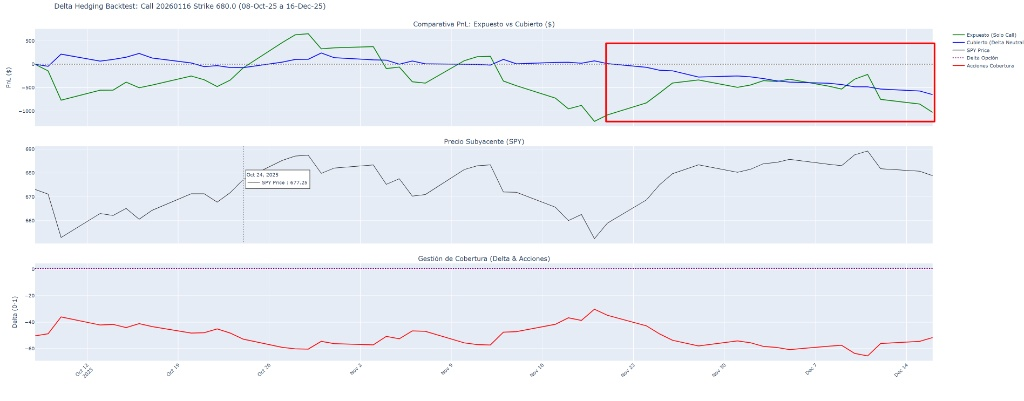

Descomposición del PnL (Profit and Loss) basada en la expansión de la Serie de Taylor de la ecuación de Black-Scholes. En una cartera Delta-Hedged (Cartera $\Pi$), eliminamos el riesgo lineal direccional ($\Delta$), pero permanecemos expuestos a los factores de orden superior. La ecuación diferencial del cambio de valor de tu cartera es:$$d\Pi \approx \underbrace{\left(\frac{\partial V}{\partial S} - \Delta_{hedge}\right)dS}_{\text{Delta PnL } (\approx 0)} + \underbrace{\frac{\partial V}{\partial \sigma} d\sigma}_{\text{Vega PnL}} + \underbrace{\frac{\partial V}{\partial t} dt}_{\text{Theta PnL}} + \underbrace{\frac{1}{2} \frac{\partial^2 V}{\partial S^2} (dS)^2}_{\text{Gamma PnL}}$$

Analicemos término por término por qué la derivada total $d\Pi$ fue negativa al final del periodo:

1. Exposición a Vega ($\mathcal{V}$):

    Riesgo de Volatilidad: La posición es largo de Call, lo que implica que esta largo de Vega ($\mathcal{V} > 0$).
    Dinámica de Mercado: Hubo una contracción de la Volatilidad Implícita (IV Crush). Matemáticamente, $d\sigma < 0$.

    Impacto en PnL:$$PnL_{Vega} = \mathcal{V} \times d\sigma$$

    Dado que $\mathcal{V}$ es positivo y $d\sigma$ es negativo, el resultado es una pérdida neta en el Mark-to-Market de la opción. La cobertura de Delta (acciones) tiene Vega cero, por lo que no ofrece inmunidad ante choques de volatilidad.

2. Decaimiento Temporal ($\Theta$): Coste de Carry

    La posición es corta de Theta ($\Theta < 0$). Eres "dueño" de la opcionalidad (Gamma), y el "precio" que pagas por esa convexidad es Theta.

    Impacto en PnL:$$PnL_{Theta} = \Theta \times dt$$

    Al acercarse el vencimiento ($T \to 0$), y estando la opción In-The-Money o Near-The-Money, el valor absoluto de Theta aumenta (se hace más negativo), acelerando la erosión de valor de la prima. Esta es la pendiente negativa constante que se ve en la curva azul.


3. Gamma ($\Gamma$) vs. Rebalanceo Discreto

    La posicion es larga de Gamma ($\Gamma > 0$).
    
    En teoría, en un mundo continuo, el término de Gamma ($\frac{1}{2}\Gamma (dS)^2$) se compensa exactamente con el término de Theta ($\Theta dt$) **si la volatilidad realizada es igual a la implícita**.

    Esto se conoce como la relación fundamental Black-Scholes:
    
     $$\Theta + \frac{1}{2}\sigma^2 S^2 \Gamma - rV = 0$$

    Realidad (Discrete Hedging Error): El rebalanceo es discreto (diario, t+1). Si el mercado cae bruscamente ($dS \ll 0$), la Delta cambia instantáneamente debido a la Gamma, pero tu hedge de acciones permanece estático hasta el cierre.

    Si la volatilidad realizada ($RV$) durante la caída es menor que la volatilidad implícita ($IV$) a la que compraste, sufres una pérdida neta conocida como Variance Risk Premium. Estás "pagando" (vía Theta) por una volatilidad esperada que el mercado no está entregando con suficiente amplitud o frecuencia para que tu Gamma Scalping recupere el coste temporal.
    
    En resumen, la caída de la línea azul (Cubierta) en el recuadro rojo se debe a que la suma de los PnL de orden superior fue negativa:

  $$\underbrace{(\mathcal{V} \cdot d\sigma)}_{\text{Muy Negativo (Caída IV)}} + \underbrace{(\Theta \cdot dt)}_{\text{Negativo (Paso tiempo)}} > \underbrace{(\frac{1}{2}\Gamma (dS)^2)}_{\text{Positivo (Scalping)}}$$

  
  El beneficio obtenido por la convexidad (Gamma) ante la caída del precio no fue suficiente para compensar la severa contracción de la volatilidad implícita (Vega) y el decaimiento temporal (Theta). La cartera estaba Delta-Neutral, pero Short Volatility Environment.

##Veamos ahora una posicion corta de Put:

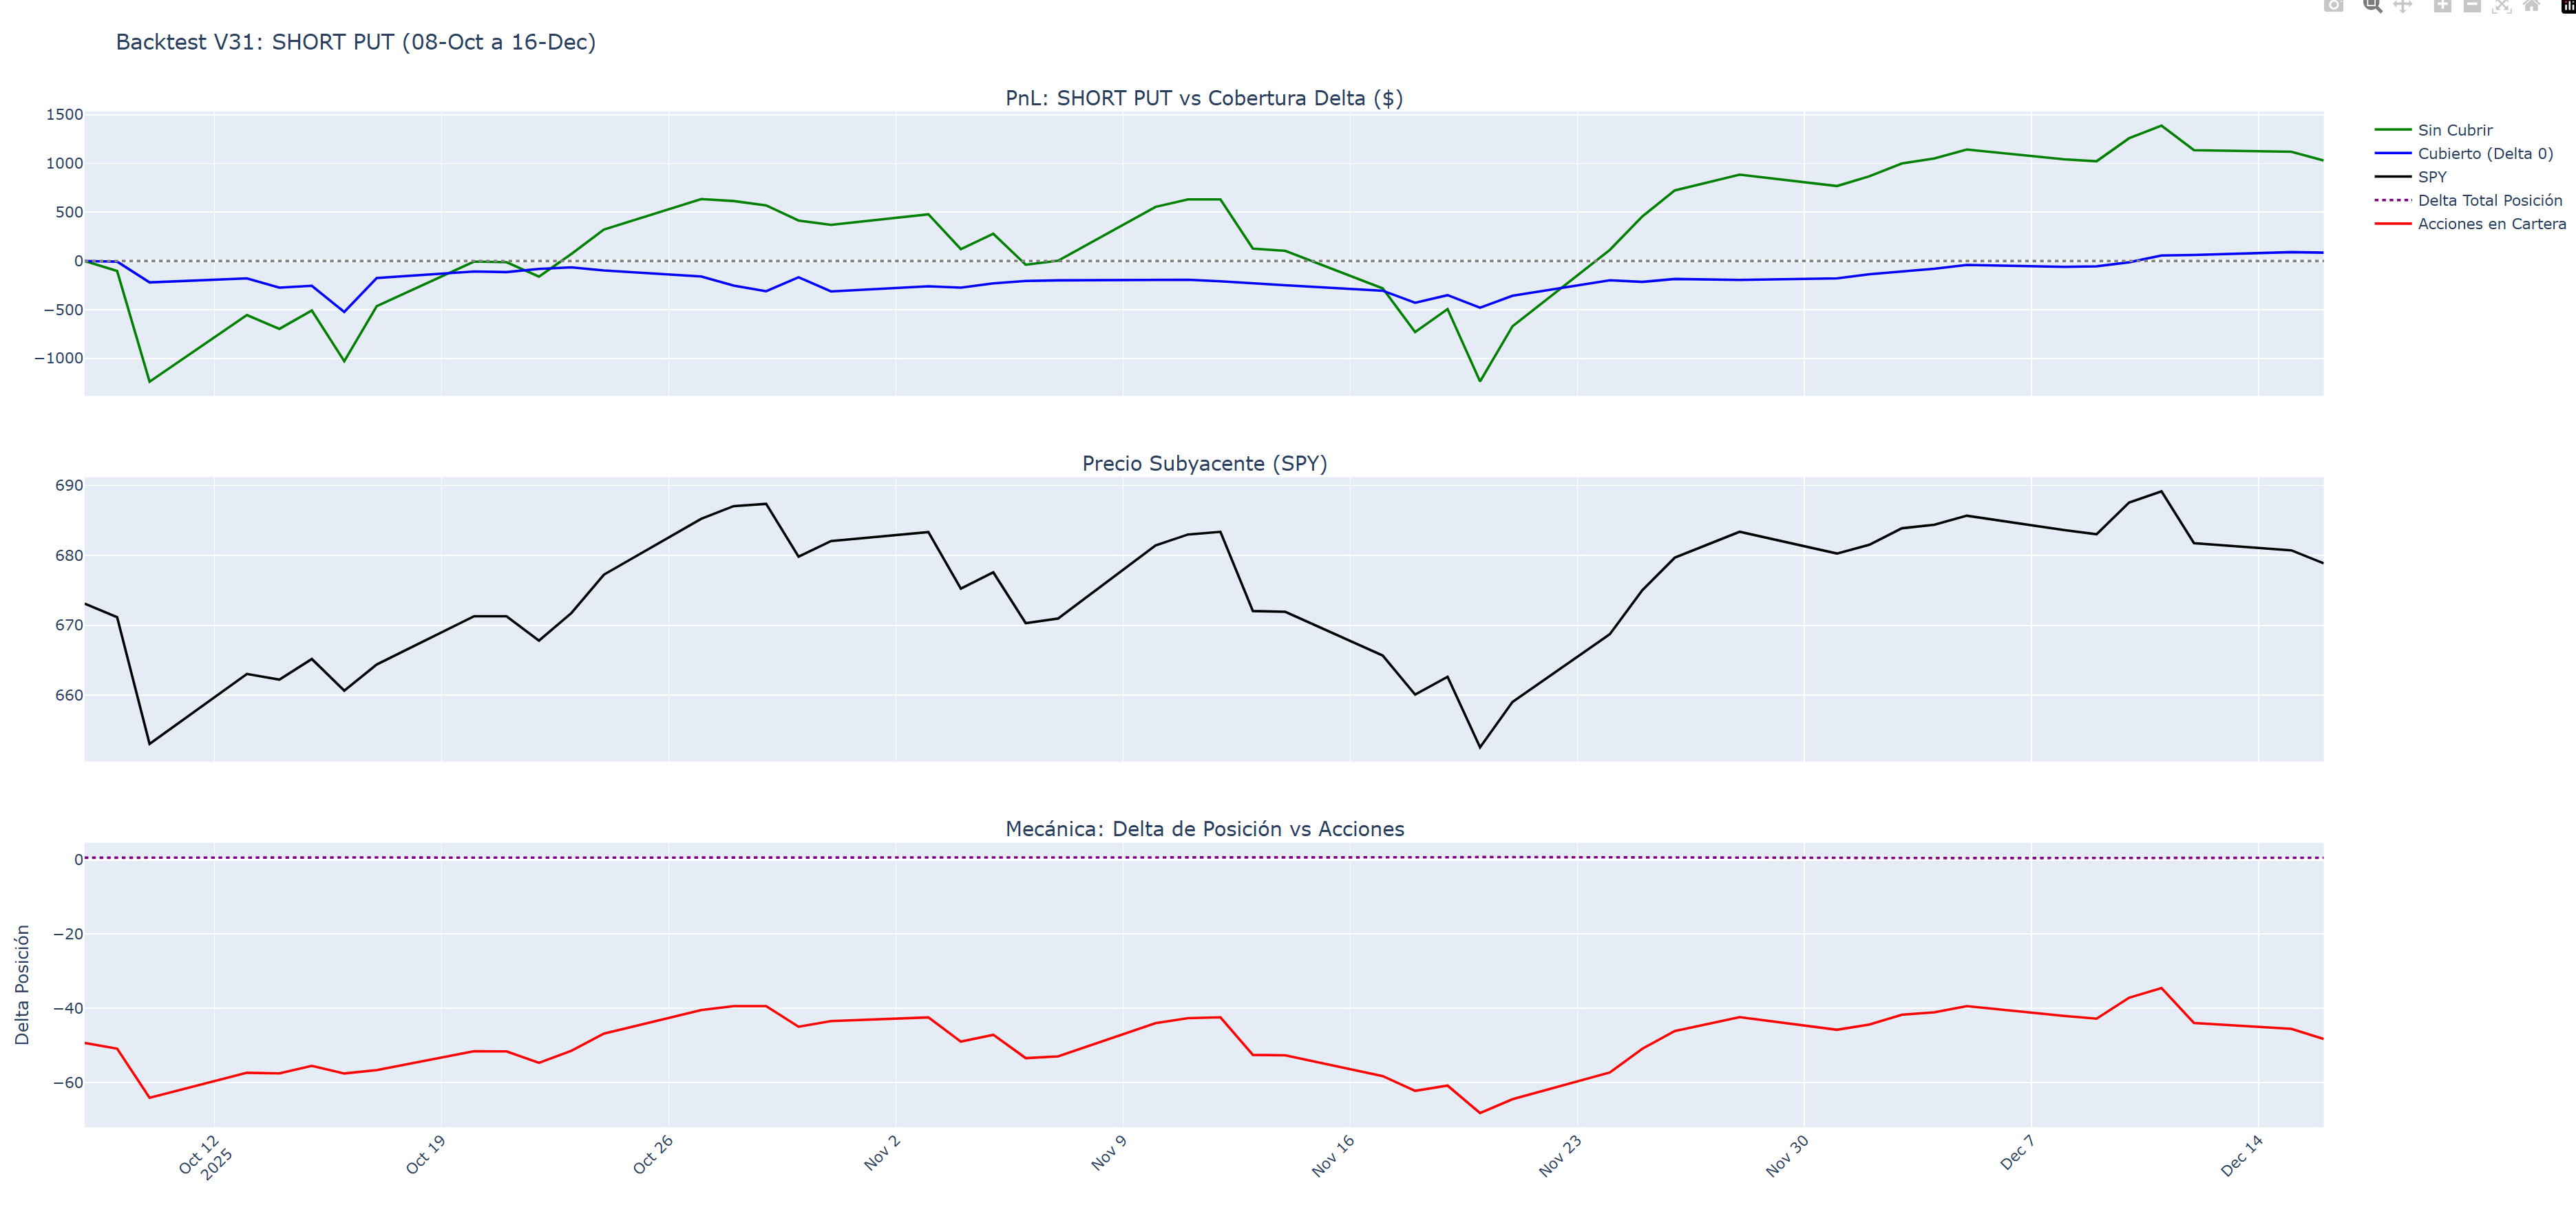

Vamos a descomponer técnicamente lo que está ocurriendo utilizando la misma atribución de PnL que antes, pero con los signos invertidos.

La ecuación de tu PnL ahora se rige por:

$$d\Pi \approx \underbrace{0}_{\text{Delta Neutral}} + \underbrace{\frac{\partial V}{\partial \sigma} d\sigma}_{\text{Vega PnL}} + \underbrace{\frac{\partial V}{\partial t} dt}_{\text{Theta PnL}} + \underbrace{\frac{1}{2} \frac{\partial^2 V}{\partial S^2} (dS)^2}_{\text{Gamma PnL}}$$

1. La Línea Roja (Gestión de Delta):
  
    Posición: La Delta (línea morada) es Positiva (aprox. +40). La posición está corta de una Put, lo cual es una posición alcista sintética.
    
    Cobertura: La línea roja muestra que se está vendido de acciones (Short Stock, -40 acciones aprox) para neutralizar esa Delta positiva.
    
    Dinámica: En la caída del mercado a mitad de gráfico (del 10 al 16 de Nov aprox). La posición corta de acciones (línea roja) se hace más grande (más negativa, vendes más). Al estar corto de Gamma, cuando el mercado cae, tu Put se vuelve más agresiva (más Delta positiva), obligándo a vender más acciones a precios peores para mantenerte neutral.

2. Theta ($\Theta$): (Positive Carry) La posición es Long Theta ($\Theta > 0$).

    Análisis: A diferencia del gráfico anterior donde la línea azul caía lentamente por el paso del tiempo, aquí la línea azul tiene una resiliencia natural al alza. Estás cobrando la prima. Cada día que pasa ($dt$), el valor temporal de la opción se erosiona. Como tú la vendiste, esa erosión es beneficio puro para tu cuenta. La línea azul se sostiene cerca de cero o sube ligeramente gracias a este flujo constante de PnL positivo proveniente de Theta.

3. Vega ($\mathcal{V}$): La posición es corta de Vega ($\mathcal{V} < 0$), y por tanto se beneficia del Colapso de IV.Vimos en el análisis anterior que la Volatilidad Implícita cayó al final del periodo, y los dos signos se compensan:

    $$PnL_{Vega} = (-\mathcal{V}) \times (-d\sigma) = \textbf{Positivo}$$
    
    Al final del gráfico, la línea azul termina en terreno positivo. Esto se debe a que la opción se desinfló por la caída de volatilidad. Al estar corto, recomprar esa opción para cerrar la posición es ahora más barato.
4. Gamma ($\Gamma$) y el Riesgo de Rebalanceo:

    La posición es corta de Gamma ($\Gamma < 0$). Está expuesta a pérdidas por convexidad $\frac{1}{2}\Gamma (dS)^2$.
    
    Cada vez que se rebalancea (la línea roja se mueve), se está "Vendiendo barato y Comprando caro". Si el mercado baja, vendes más acciones a precios cada vez mas bajos. Si el mercado sube, recompras acciones cada vez mas caras.
    

Conclusión del Gráfico: La línea azul es notablemente estable. Esto significa que las pérdidas por Gamma (rebalanceo) fueron menores que las ganancias por Theta + Vega. El mercado no fue lo suficientemente violento para que el coste de estar corto en Gamma destruyera el beneficio de cobrar la prima temporal.
    
    

##8.	Simular el envío de una orden y de su cobertura. ¿Qué problemas pueden surgir?

##Algoritmo de Ejecución y Cobertura

Este módulo cierra el ciclo operativo, gestionando el ciclo de vida completo de una operación de volatilidad:

Ejecución $\to$ Cobertura $\to$ Monitorización.

### 1. Algoritmo de Ejecución ("Limit Chase")
La función `ejecutar_orden_algoritmica` implementa una estrategia de entrada agresiva-pasiva.
* **El Problema:** Las órdenes de mercado (`MarketOrder`) garantizan ejecución pero no precio (alto coste de spread). Las órdenes límite (`LimitOrder`) garantizan precio pero no ejecución.
* **La Lógica:** El algoritmo coloca una orden límite inicial en el precio de referencia. Si no se ejecuta en $N$ segundos (simulado por `ib.sleep`), "camina" el precio (`step = 0.05`) acercándose a la contrapartida.
* Esto minimiza el **Slippage** (deslizamiento) y el impacto en mercado, buscando un equilibrio óptimo entre urgencia y coste.



### 2. Cobertura Delta-Neutral Automatizada
Una vez confirmada la ejecución de la opción ("Fill"), el sistema dispara `ejecutar_cobertura`.
* **Riesgo de Ejecución ("Legging Risk"):** Existe un riesgo latente entre el momento en que se compra la opción y se venden las acciones. Si el mercado se mueve violentamente en esos milisegundos, la cobertura podría ser imperfecta.
* **Cálculo:** Se utiliza la aproximación estándar:
    $$\text{Hedge Qty} = \text{Round}( \Delta_{opción} \times \text{Contratos} \times 100 ) \times (-1)$$
    El $(-1)$ asegura que si la opción nos da Delta Positivo (Long Call), vendamos acciones (Short Stock), y viceversa.

### 3. Arquitectura de Seguridad (Flag de Simulación)
Dado que este script tiene capacidad de escritura (envío de órdenes), la variable `MODO_SIMULACION` actúa como un "Kill Switch" lógico.
* **True:** El sistema "alucina" las ejecuciones. Simula latencias y precios de llenado sin contactar con el *matching engine* de la bolsa. Es vital para *Forward Testing* (probar la lógica en tiempo real sin dinero).
* **False:** El sistema conecta con la pasarela de órdenes de IBKR. Aquí, el código gestiona identificadores de órdenes reales (`orderId`) y estados de ejecución (`orderStatus`).

### 4. Bucle de Monitorización (Gamma Risk)
La función `monitor_riesgo_continuo` aborda el problema de la **Gamma** ($\Gamma$).
* Aunque la posición nace Delta-Neutral, el precio del subyacente cambia constantemente. Como la Delta no es constante (debido a la Gamma), la cobertura se desajusta minuto a minuto.
* El bucle infinito vigila la `net_delta`. Si supera un umbral (`threshold=10`), emite una alerta de rebalanceo. En un sistema 100% autónomo, esta alerta dispararía otra orden de cobertura automáticamente.

In [ ]:
# -*- coding: utf-8 -*-
"""
Ejercicio Máster V42: SISTEMA ALGORÍTMICO DE EJECUCIÓN Y COBERTURA
------------------------------------------------------------------
DESCRIPCIÓN:
Algoritmo de ejecución secuencial para posicionamiento en opciones
con cobertura delta-neutral inmediata y monitorización continua de riesgo.

MODOS DE OPERACIÓN:
- MODO_SIMULACION = True:
    Ejecución virtual. Útil para validación de lógica (Backtest/Forward Test)
    o cuando el mercado (CBOE/OPRA) se encuentra cerrado.

- MODO_SIMULACION = False:
    Ejecución real. Envía órdenes vivas a la pasarela de Interactive Brokers.
"""

import time
import math
import datetime as dt
from ib_insync import IB, Stock, Option, LimitOrder, MarketOrder

# --- CONFIGURACIÓN DE ENTORNO ---
#OJO VA A LANZAR ORDENES A LA API CUANDO ESTE A FALSE - VERIFICAR PUERTO
MODO_SIMULACION = FALSE  # <--- True: Entorno Virtual | False: Entorno Real (TWS)
# --------------------------------

def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def calculate_delta(S, K, T, r, q, iv, right):
    if S <= 0 or K <= 0: return 0.5
    try:
        d1 = (math.log(S/K) + (r - q + 0.5*iv**2)*T) / (iv*math.sqrt(T))
        eqT = math.exp(-q*T)
        if right == "C": return eqT * norm_cdf(d1)
        else: return eqT * (norm_cdf(d1) - 1.0)
    except: return 0.5

def log(msg, tipo="INFO"):
    """
    Sistema de Logging estandarizado.
    Tipos: INFO, EXEC (Ejecución), MKT (Datos Mercado), ALERT (Riesgo).
    """
    timestamp = dt.datetime.now().strftime('%H:%M:%S')
    prefix = "[SIMULACIÓN]" if MODO_SIMULACION else "[MERCADO REAL]"
    print(f"{timestamp} | {prefix:15} | {tipo:5} | {msg}")

def mostrar_aviso_legal():
    print("\n" + "=" * 80)
    if MODO_SIMULACION:
        print(" ESTADO: MODO SIMULACIÓN / FUERA DE HORARIO DE MERCADO")
        print(" DETALLE: Las órdenes se procesarán internamente. No hay riesgo de capital.")
    else:
        print(" ESTADO: !!! OPERATIVA EN MERCADO REAL (LIVE) !!!")
        print(" DETALLE: Las órdenes se enviarán al Smart Routing de IBKR.")
        print(" RIESGO: Capital en riesgo. Asegúrese de que la TWS está supervisada.")
    print("=" * 80 + "\n")

# --- MÓDULO DE DATOS DE MERCADO ---
def obtener_precio_referencia(ib, contract):
    """
    Obtiene el precio más fiable disponible.
    Detecta si el mercado está cerrado (datos históricos) o abierto (datos live).
    """
    ib.reqMarketDataType(3) # 3 = Datos diferidos/congelados
    ticker = ib.reqMktData(contract, "", False, False)
    ib.sleep(2)

    origen_dato = "LIVE/DELAYED"
    price = 0.0

    if ticker.last > 0: price = ticker.last
    elif ticker.close > 0: price = ticker.close

    # Si no hay datos recientes, asumimos mercado cerrado y bajamos histórico
    if price == 0:
        bars = ib.reqHistoricalData(contract, '', '2 D', '1 day', 'TRADES', 1, 1, False, [])
        if bars:
            price = bars[-1].close
            origen_dato = "CIERRE ANTERIOR (MERCADO CERRADO)"

    log(f"Precio ref: {price:.2f} ({origen_dato})", "MKT")
    return price

# --- FASE 1: ALGORITMO DE EJECUCIÓN (LÍMITE ADAPTATIVO) ---
def ejecutar_orden_algoritmica(ib, contract, action, qty, max_price_cap):
    log(f"Iniciando secuencia de ejecución: {action} {qty}x {contract.localSymbol}", "EXEC")

    start_price = obtener_precio_referencia(ib, contract)
    if start_price == 0: start_price = 5.0 # Precio base seguridad

    current_limit = start_price
    step = 0.05 # Tick de mejora

    # --- RAMA SIMULACIÓN (Mercado Cerrado o Test) ---
    if MODO_SIMULACION:
        log(f"Simulando envío de orden LÍMITE a {current_limit:.2f}...", "EXEC")
        # Simulamos la latencia y el deslizamiento de precio
        for i in range(3):
            ib.sleep(2)
            if action == "BUY": current_limit += step
            else: current_limit -= step
            log(f"Orden no ejecutada. Ajustando límite a {current_limit:.2f}...", "INFO")

        log(f"Ejecución Virtual Confirmada @ {current_limit:.2f}", "EXEC")
        return current_limit

    # --- RAMA REAL (Conexión TWS) ---
    else:
        order = LimitOrder(action, qty, current_limit)
        trade = ib.placeOrder(contract, order)
        log(f"Orden enviada a IBKR (Id: {trade.order.orderId}) @ {current_limit:.2f}", "EXEC")

        while not trade.isDone():
            ib.sleep(5)
            if trade.isDone(): break

            # Lógica de persecución de precio
            if action == "BUY":
                new_price = round(current_limit + step, 2)
                if new_price > max_price_cap:
                    ib.cancelOrder(order); return None
            else:
                new_price = round(current_limit - step, 2)
                if new_price < max_price_cap:
                    ib.cancelOrder(order); return None

            log(f"Sin liquidez. Modificando orden a {new_price:.2f}...", "INFO")
            order.lmtPrice = new_price
            trade = ib.placeOrder(contract, order)
            current_limit = new_price

        fill_price = trade.orderStatus.avgFillPrice
        log(f"Orden completada en mercado @ {fill_price:.2f}", "EXEC")
        return fill_price

# --- FASE 2: GESTIÓN DE DELTA (COBERTURA) ---
def ejecutar_cobertura(ib, symbol_stock, opt_contract, opt_qty, opt_action, strike):
    log("Iniciando módulo de cobertura Delta-Neutral...", "INFO")

    stock = Stock(symbol_stock, "SMART", "USD")
    ib.qualifyContracts(stock)
    S = obtener_precio_referencia(ib, stock)

    # Cálculo de Griegas
    r, q, iv = 0.045, 0.015, 0.16
    try:
        exp_dt = dt.datetime.strptime(opt_contract.lastTradeDateOrContractMonth, "%Y%m%d")
        T = max((exp_dt - dt.datetime.now()).days, 1) / 365.0
    except: T = 0.1

    delta_unit = calculate_delta(S, strike, T, r, q, iv, opt_contract.right)
    side = 1 if opt_action == "BUY" else -1
    total_delta = delta_unit * opt_qty * 100 * side

    log(f"Análisis Riesgo: Delta Unit {delta_unit:.2f} | Exposición Neta {total_delta:.1f}", "INFO")

    hedge_qty = int(round(abs(total_delta)))
    hedge_side = "SELL" if total_delta > 0 else "BUY"

    if hedge_qty > 0:
        if MODO_SIMULACION:
            log(f"Simulando orden MERCADO: {hedge_side} {hedge_qty} {symbol_stock}", "EXEC")
            ib.sleep(1)
            log("Cobertura virtual confirmada.", "EXEC")
        else:
            log(f"Enviando orden MERCADO a IBKR: {hedge_side} {hedge_qty} {symbol_stock}", "EXEC")
            order = MarketOrder(hedge_side, hedge_qty)
            trade = ib.placeOrder(stock, order)
            while not trade.isDone(): ib.sleep(0.5)
            real_price = trade.orderStatus.avgFillPrice
            log(f"Cobertura ejecutada @ {real_price:.2f}", "EXEC")

        return -hedge_qty if hedge_side == "SELL" else hedge_qty
    else:
        log("Exposición residual despreciable. No se requiere cobertura.", "INFO")
        return 0

# --- FASE 3: MONITORIZACIÓN DE RIESGO (DELTA) ---
def monitor_riesgo_continuo(ib, stock, opt_contract, strike, my_opt_qty, my_stock_qty, threshold=10):
    log("Activando monitor de riesgo en tiempo real...", "INFO")
    log(f"Posición Actual: {my_opt_qty} Opciones vs {my_stock_qty} Acciones", "INFO")

    r, q, iv = 0.045, 0.015, 0.16
    exp_dt = dt.datetime.strptime(opt_contract.lastTradeDateOrContractMonth, "%Y%m%d")

    try:
        while True:
            ib.sleep(5)
            # Usamos obtener_precio para que funcione incluso con mercado cerrado (simulación)
            # En real, usaríamos reqMktData directamente para menor latencia
            S = obtener_precio_referencia(ib, stock)

            T = max((exp_dt - dt.datetime.now()).days, 1) / 365.0
            d_unit = calculate_delta(S, strike, T, r, q, iv, opt_contract.right)

            delta_opts = d_unit * my_opt_qty * 100
            delta_stk  = my_stock_qty
            net_delta  = delta_opts + delta_stk

            status = "NEUTRAL"
            tipo_msg = "INFO"

            if abs(net_delta) > threshold:
                status = "DESVIACIÓN DETECTADA"
                tipo_msg = "ALERT"

            log(f"Spot: {S:.2f} | Delta Neta: {net_delta:.2f} [{status}]", tipo_msg)

            if abs(net_delta) > threshold:
                action = "VENDER" if net_delta > 0 else "COMPRAR"
                adj = int(round(abs(net_delta)))
                log(f"Recomendación de Rebalanceo: {action} {adj} acciones.", "ALERT")

    except KeyboardInterrupt:
        log("Monitorización detenida por el usuario.", "INFO")

# --- MAIN ---
if __name__ == "__main__":
    HOST = "127.0.0.1"; PORT = 7497; CLIENT_ID = 108

    # PARÁMETROS DE LA ORDEN
    SYMBOL = "SPY"
    EXP = "20260116"
    STRIKE = 680
    OP_TYPE = "C"
    ACTION = "BUY"
    QTY = 1
    MAX_PRICE_CAP = 30.00

    mostrar_aviso_legal()

    x = input("Escriba 'INICIAR' para ejecutar el algoritmo: ")

    if x.upper() == "INICIAR":
        ib = IB()
        try:
            ib.connect(HOST, PORT, clientId=CLIENT_ID)

            # Definición de contrato
            contract_opt = Option(SYMBOL, EXP, STRIKE, OP_TYPE, "SMART")
            ib.qualifyContracts(contract_opt)

            # 1. EJECUCIÓN
            fill_price = ejecutar_orden_algoritmica(ib, contract_opt, ACTION, QTY, MAX_PRICE_CAP)

            if fill_price:
                qty_signed = QTY if ACTION=="BUY" else -QTY

                # 2. COBERTURA
                shares_held = ejecutar_cobertura(ib, SYMBOL, contract_opt, QTY, ACTION, STRIKE)

                # 3. VIGILANCIA
                stock = Stock(SYMBOL, "SMART", "USD")
                ib.qualifyContracts(stock)
                monitor_riesgo_continuo(ib, stock, contract_opt, STRIKE, qty_signed, shares_held)
            else:
                log("El algoritmo no pudo completar la orden dentro de los parámetros.", "ALERT")

        except Exception as e:
            print(f"ERROR CRÍTICO DEL SISTEMA: {e}")
        finally:
            ib.disconnect()
    else:
        print("Operación cancelada.")

#**Taxonomía de Riesgos para Ejecución Algorítmica de Derivados.**


---

## **1. Riesgos de Ejecución y Microestructura (El "Momento de la Verdad")**

Estos ocurren en los milisegundos que tardas en entrar y salir del mercado.

#### **1.1. Riesgo de Ejecución Asíncrona (*Legging Risk*)**

* **Definición:** La exposición direccional no deseada durante el tiempo que pasa entre que se ejecuta la opción y se ejecuta la cobertura.
* **Causa:** La naturaleza secuencial del algoritmo (Opción \rightarrow Acción).
* **Impacto:** Pérdida inmediata (*Mark-to-Market*) si el mercado se mueve en tu contra durante ese intervalo.

#### **1.2. Déficit de Implementación (*Slippage*)**

* **Definición:** La diferencia negativa entre el precio teórico del modelo y el precio real de ejecución.
* **Causa:** Volatilidad intradía, ampliación del *spread* o latencia.
* **Impacto:** Coste operativo que erosiona la ventaja matemática (Theta) de la estrategia.

#### **1.3. Riesgo de Llenado Parcial (*Partial Fill Risk*)**

* **Definición:** Recibir solo una parte de la orden de opciones solicitada.
* **Causa:** Falta de liquidez en el nivel de precio límite.
* **Impacto:** Riesgo de **Sobre-Cobertura (*Over-Hedging*)** si el algoritmo cubre el total planeado en lugar del total ejecutado, invirtiendo la dirección del riesgo.

#### **1.4. Riesgo de Liquidez y Profundidad (*Market Depth Risk*)**

* **Definición:** Incapacidad de ejecutar grandes volúmenes sin mover el precio en contra (*Market Impact*).
* **Causa:** Libros de órdenes delgados (*Thin Order Books*) en las opciones.
* **Impacto:** Imposibilidad de cerrar o cubrir una posición rápidamente en momentos de pánico.

---

## **2. Riesgos Tecnológicos y de Infraestructura (Los "Cables")**

Fallos en el software, hardware o redes que soportan tu algoritmo.

#### **2.1. Latencia de Red (*Round-Trip Latency*)**

* **Definición:** El retraso entre la generación de la señal y la confirmación del *exchange*.
* **Causa:** Congestión de internet, lentitud de la API o distancia física a los servidores.
* **Impacto:** **Riesgo de Cotización Obsoleta (*Stale Quote Risk*)**. Operar basándose en precios que ya no existen.

#### **2.2. Fallo de Conexión (*Heartbeat / Session Failure*)**

* **Definición:** Pérdida de comunicación con la pasarela (TWS/Gateway).
* **Causa:** Reinicios diarios del bróker, cortes de ISP o excepciones de software no capturadas.
* **Impacto:** **Posición Huérfana (*Orphaned Position*)**. La opción se ejecuta pero el robot "muere" antes de lanzar la cobertura, dejando la cuenta expuesta sin vigilancia.

#### **2.3. Limitación de Tasa (*API Pacing Violation*)**

* **Definición:** Bloqueo temporal por enviar demasiadas solicitudes por segundo.
* **Causa:** Bucles `while` sin `sleep` adecuado o solicitudes de datos excesivas.
* **Impacto:** Rechazo de órdenes críticas de cobertura o ceguera temporal (falta de datos).

#### **2.4. Datos Sucios (*Bad Ticks / Dirty Data*)**

* **Definición:** Recepción de precios erróneos (ej. precio 0.00 o picos irreales).
* **Causa:** Errores en el proveedor de datos de mercado.
* **Impacto:** Falsos positivos en el "Watchdog" que provocan rebalanceos masivos innecesarios y costosos.

---

## **3. Riesgos de Modelo y Matemáticos (La "Fórmula")**

Discrepancias entre tu simulación teórica y la realidad física.

#### **3.1. Error de Discretización (*Discrete Hedging Error*)**

* **Definición:** La imposibilidad de replicar la cobertura continua perfecta que asume Black-Scholes.
* **Causa:** Restricciones de lotes enteros (*Lot Size*) en acciones (no puedes vender 0.4 acciones).
* **Impacto:** **Delta Residual**. Siempre existe un pequeño riesgo direccional (ruido) imposible de eliminar.

#### **3.2. Riesgo de Calibración (*Parameter Estimation Risk*)**

* **Definición:** Cálculo incorrecto de Delta por usar *inputs* erróneos.
* **Causa:** Usar una Tasa Libre de Riesgo (r) o Dividendos (q) fijos en lugar de los implícitos del mercado.
* **Impacto:** Cobertura sesgada. Crees estar neutral, pero estás largo o corto estructuralmente.

#### **3.3. Riesgo de Volatilidad Estocástica (*Vol Surface Risk*)**

* **Definición:** Asumir que la Volatilidad Implícita es constante.
* **Causa:** Cambios en la oferta/demanda de opciones (Skew/Smile).
* **Impacto:** La Delta cambia no solo por el precio (Gamma), sino por cambios en la volatilidad (*Vanna*), desajustando la cobertura.

---

## **4. Riesgos Financieros y Regulatorios**

Restricciones de capital y normativas del bróker.

#### **4.1. Riesgo de Inventario (*Hard-to-Borrow Risk*)**

* **Definición:** Imposibilidad de ponerse corto en la acción para cubrir una *Long Call*.
* **Causa:** Falta de acciones prestables en el bróker.
* **Impacto:** Rechazo de la orden de cobertura, dejando la posición "desnuda".

#### **4.2. Riesgo de Margen (*Liquidation Risk*)**

* **Definición:** Cierre forzoso de posiciones por falta de garantías.
* **Causa:** Apalancamiento excesivo o expansión de volatilidad que aumenta los requisitos de margen.
* **Impacto:** Realización de pérdidas en el peor momento posible sin control del algoritmo.

#### **4.3. Riesgo de Asignación (*Assignment Risk*)**

* **Definición:** Ejercicio anticipado de opciones americanas (si estás corto de opciones).
* **Causa:** La opción es ITM profunda o hay un dividendo próximo.
* **Impacto:** Destrucción de la estructura de cobertura y aparición de posiciones de contado inesperadas.

#### **4.4. Regla PDT (*Pattern Day Trader*)**

* **Definición:** Bloqueo de la cuenta por operar intradía con menos de $25k.
* **Causa:** Normativa FINRA/SEC.
* **Impacto:** Congelación de la capacidad de abrir nuevas posiciones para corregir riesgos.

#### **4.5. Coste de Préstamo (*Borrow Fees*)**

* **Definición:** Intereses diarios pagados por mantener acciones cortas.
* **Causa:** Alta demanda de cortos en el activo (*High Short Interest*).
* **Impacto:** El coste financiero supera al beneficio por Theta, haciendo la estrategia no rentable.

---

## **5. Riesgos de Dinámica de Mercado (El "Entorno")**

Movimientos del activo que desafían las asunciones del modelo.

#### **5.1. Riesgo de Hueco (*Gap Risk*)**

* **Definición:** Movimiento brusco del precio sin cotización intermedia (ej. apertura de mercado o noticia).
* **Causa:** Eventos exógenos fuera de horario.
* **Impacto:** Imposibilidad de rebalancear (Gamma Hedging). La pérdida es instantánea y mayor a la predicha por la Delta local.

#### **5.2. Riesgo de Vega (*Volatility Crush*)**

* **Definición:** Pérdida de valor de la opción por caída de la Volatilidad Implícita.
* **Causa:** Resolución de incertidumbre (ej. tras unos resultados o reunión de la FED).
* **Impacto:** Pérdida en posiciones *Long Gamma* (Compradas) que la cobertura Delta no protege.

#### **5.3. Riesgo de Gamma (*Explosive Rebalancing*)**

* **Definición:** Necesidad de rebalancear cantidades cada vez mayores a medida que el mercado se mueve en contra (si estás Short Gamma).
* **Causa:** Convexidad negativa de la posición vendida.
* **Impacto:** "Vender barato y comprar caro" repetidamente hasta agotar el capital (Riesgo de Ruina).